# 🔬 Hybrid Retriever Debug Lab

Este notebook investiga passo a passo o problema de performance degradada no retriever híbrido, comparando resultados individuais vs combinados, especialmente focando em:

1. **Normalização dupla**: Como a normalização após concatenação afeta o balanceamento entre slices
2. **Escalonamento TF-IDF**: Como `√(D_s/D_t)` se comporta diferente para MiniLM (384 dim) vs BGE-Large (1024 dim)
3. **Prefixos BGE**: Verificar se a falta de prefixos degrada performance do BGE-Large
4. **Balanceamento de slices**: Entender a contribuição relativa de cada modalidade

**Dataset**: SciFact (subsample ~100 docs, ~20 queries)  
**Modelos**: MiniLM-L6-v2 vs BGE-Large-en-v1.5


## 1. Setup e Preparação


In [1]:
import sys
import os
import warnings
import platform
from pathlib import Path

# ===== CONFIGURAÇÕES CRÍTICAS PARA macOS (ANTES DE QUALQUER IMPORTAÇÃO) =====
# Essas configurações devem vir ANTES de importar sentence-transformers ou transformers
# para evitar crashes de multiprocessing no macOS
if platform.system() == 'Darwin':
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    print("✓ Configurações macOS aplicadas (multiprocessing seguro)")

# Configurar multiprocessing para macOS (deve ser ANTES de qualquer import que use multiprocessing)
import multiprocessing
try:
    multiprocessing.set_start_method('spawn', force=True)
except RuntimeError:
    # Já foi configurado, não é problema
    pass

# Agora podemos importar o resto com segurança
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional

# Setup paths
repo_root = Path.cwd()
while repo_root != repo_root.parent and repo_root.name != "hybrid-retrieval":
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


✓ Configurações macOS aplicadas (multiprocessing seguro)
Repo root: /Users/thiago/Documents/GitHub/hybrid-retrieval


In [2]:
# Imports do projeto
from src.datasets.loader import load_beir_dataset, select_split, as_documents, as_queries
from src.datasets.schema import Document, Query
from src.retrievers.dense_faiss import DenseFaiss
from src.retrievers.tfidf_faiss import TFIDFRetriever
from src.retrievers.graph_faiss import GraphRetriever
from src.vectorizers.bi_modal_vectorizer import BiModalVectorizer
from src.vectorizers.tri_modal_vectorizer import TriModalVectorizer
from src.indexes.hybrid_index import HybridIndex
from src.eval.evaluator import evaluate_predictions
from src.encoders.encoders import l2norm

print("Imports concluídos!")


Imports concluídos!


In [3]:
def load_subset_scifact(n_docs: int = 100, n_queries: int = 20):
    """Carrega um subset pequeno do SciFact para debug rápido."""
    root = repo_root / "data" / "scifact" / "processed" / "beir"
    corpus, queries, qrels = load_beir_dataset(root)
    
    # Seleciona split test
    split = select_split(qrels, ("test", "dev", "validation", "train"))
    qrels_split = qrels[qrels["split"] == split].copy()
    
    # Pega apenas docs referenciados nos qrels
    used_doc_ids = set(qrels_split["doc_id"].astype(str).unique().tolist())
    subset_corpus = corpus[corpus["doc_id"].astype(str).isin(used_doc_ids)].head(n_docs)
    
    # Pega queries do split (limitado)
    qids = list(qrels_split["query_id"].astype(str).unique())[:n_queries]
    subset_queries = queries[queries["query_id"].isin(qids)]
    
    # Filtra qrels para apenas os docs e queries selecionados
    qrels_filtered = qrels_split[
        (qrels_split["doc_id"].astype(str).isin(subset_corpus["doc_id"].astype(str))) &
        (qrels_split["query_id"].astype(str).isin(qids))
    ].copy()
    
    docs = as_documents(subset_corpus)
    qlist = as_queries(subset_queries)
    
    return docs, qlist, qrels_filtered

docs, queries, qrels = load_subset_scifact(n_docs=100, n_queries=20)

print(f"📊 Dataset carregado:")
print(f"  - Documentos: {len(docs)}")
print(f"  - Queries: {len(queries)}")
print(f"  - Qrels: {len(qrels)} pares (query, doc)")
print(f"  - Queries únicas com relevantes: {qrels['query_id'].nunique()}")


📊 Dataset carregado:
  - Documentos: 100
  - Queries: 20
  - Qrels: 11 pares (query, doc)
  - Queries únicas com relevantes: 10


In [4]:
# Funções auxiliares de visualização e inspeção

def inspect_vector_norms(vecs: List[np.ndarray], labels: Optional[List[str]] = None) -> pd.DataFrame:
    """Calcula normas L2 de uma lista de vetores."""
    norms = [np.linalg.norm(v) for v in vecs]
    df = pd.DataFrame({"norm": norms})
    if labels:
        df["label"] = labels
    return df

def plot_norm_distribution(norms_dict: Dict[str, np.ndarray], title: str = "Distribuição de Normas L2"):
    """Plota histograma comparativo de normas."""
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, norms in norms_dict.items():
        ax.hist(norms, bins=30, alpha=0.6, label=label, edgecolor='black')
    ax.set_xlabel("Norma L2")
    ax.set_ylabel("Frequência")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def compare_slice_contributions(slices: Dict[str, np.ndarray], title: str = "Contribuição Relativa dos Slices"):
    """Visualiza contribuição relativa de cada slice antes da normalização final."""
    norms = {name: np.linalg.norm(vec) for name, vec in slices.items()}
    total_norm = np.sqrt(sum(n**2 for n in norms.values()))
    
    # Contribuição relativa (norma de cada slice / norma total do vetor concatenado)
    contrib = {name: n / total_norm for name, n in norms.items()}
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras com normas absolutas
    names = list(norms.keys())
    values = [norms[n] for n in names]
    ax1.bar(names, values, alpha=0.7, edgecolor='black')
    ax1.set_ylabel("Norma L2")
    ax1.set_title("Normas Absolutas dos Slices")
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Gráfico de barras com contribuição relativa
    contrib_values = [contrib[n] for n in names]
    ax2.bar(names, contrib_values, alpha=0.7, edgecolor='black', color='orange')
    ax2.set_ylabel("Contribuição Relativa")
    ax2.set_title("Contribuição Relativa (antes normalização final)")
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Retorna DataFrame resumo
    return pd.DataFrame({
        "slice": names,
        "norma_absoluta": values,
        "norma_total_concat": [total_norm] * len(names),
        "contribuicao_relativa": contrib_values
    })

def plot_similarity_heatmap(similarities: np.ndarray, labels: Optional[List[str]] = None, 
                            title: str = "Similaridade Cosseno"):
    """Plota heatmap de similaridades (para subset pequeno)."""
    if labels is None:
        labels = [f"Item {i}" for i in range(len(similarities))]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(similarities, annot=True, fmt='.3f', cmap='viridis', 
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

print("Funções auxiliares definidas!")


Funções auxiliares definidas!


## 2. Análise dos Retrievers Individuais

Vamos primeiro entender como cada retriever individual funciona e performa, para depois comparar com as combinações híbridas.


### 2.1 Dense Retriever - MiniLM-L6-v2


In [5]:
# Inicializar retriever denso com MiniLM
retriever_dense_minilm = DenseFaiss(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    device="cpu",  # Usar CPU para consistência
    query_prefix="",
    doc_prefix="",
)

print(f"Modelo: {retriever_dense_minilm.vec.encoder.model_name}")
print(f"Dimensão: {retriever_dense_minilm.dim}")


/Users/thiago/Documents/GitHub/hybrid-retrieval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modelo: sentence-transformers/all-MiniLM-L6-v2
Dimensão: 384


In [6]:
# Inspecionar embeddings: normas e dimensões
# Versão com proteções para macOS/multiprocessing

# Garantir que sentence-transformers não use multiprocessing (crítico para macOS)
if platform.system() == 'Darwin':
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

sample_texts = [
    "Clinical trials show efficacy of mRNA vaccines against COVID-19.",
    "Interest rates and equity volatility impact market valuations.",
    "Graph neural networks for entity classification."
]

print("=== Inspeção de Embeddings (MiniLM) ===\n")
if platform.system() == 'Darwin':
    print("ℹ️  macOS detectado: usando configurações seguras (sem multiprocessing)\n")

# Primeiro, testar com um texto simples para garantir que o modelo está carregado
try:
    print("Testando carregamento do modelo com texto simples...")
    # Verificar se o modelo já está carregado
    encoder = retriever_dense_minilm.vec.encoder
    if encoder._model is None:
        print("  Modelo ainda não carregado, carregando agora...")
    
    test_emb = retriever_dense_minilm.vec.encode_doc("test")
    print(f"✓ Modelo carregado. Dimensão do embedding: {len(test_emb)}")
except Exception as e:
    print(f"❌ Erro ao carregar modelo: {type(e).__name__}: {e}")
    print("\nPossíveis causas:")
    print("  - Problema de memória")
    print("  - Modelo corrompido") 
    print("  - Conflito de multiprocessing no macOS")
    print("\nSolução: Reinicie o kernel e execute novamente a partir da primeira célula.")
    raise

# Processar embeddings com tratamento de erro robusto
normalized_embeddings = []

print("\nProcessando embeddings dos textos de exemplo...\n")

for i, text in enumerate(sample_texts):
    try:
        print(f"  [{i+1}/{len(sample_texts)}] '{text[:50]}...'", end=" ... ", flush=True)
        
        # Usar encode_doc que já faz a normalização de forma segura
        # Ele usa batch_size=1 internamente (via encode_doc), evitando multiprocessing
        emb = retriever_dense_minilm.vec.encode_doc(text)
        normalized_embeddings.append(emb)
        
        norm_val = np.linalg.norm(emb)
        print(f"✓ (norma: {norm_val:.6f})")
        
    except Exception as e:
        print(f"❌ Erro: {type(e).__name__}: {str(e)[:100]}")
        # Se falhar, pular este texto mas continuar
        if len(normalized_embeddings) == i:
            # Apenas se ainda não tiver nenhum, criar fallback
            normalized_embeddings.append(np.zeros(retriever_dense_minilm.dim, dtype=np.float32))

print("\n✓ Processamento concluído\n")

# Estatísticas
if len(normalized_embeddings) > 0:
    norm_norms = [np.linalg.norm(v) for v in normalized_embeddings]
    
    df_norms = pd.DataFrame({
        "texto": [t[:50] + "..." for t in sample_texts[:len(normalized_embeddings)]],
        "dimensão": [len(v) for v in normalized_embeddings],
        "norma_L2": norm_norms,
    })

    print(df_norms.to_string(index=False))
    print(f"\n✓ Todas as normas ≈ 1.0? {np.allclose(norm_norms, 1.0, atol=1e-5)}")
    print(f"  (Tolerância: 1e-5, desvio máximo: {max(abs(np.array(norm_norms) - 1.0)):.6f})")
    print(f"\nNota: O encoder já normaliza os embeddings internamente (ver dense_vectorizer.py)")
    print(f"      Por isso não mostramos 'raw' vs 'normalizado' - ambos são normalizados.")
else:
    print("❌ Não foi possível processar nenhum embedding. Verifique os erros acima.")
    print("   Dica: Tente reiniciar o kernel e executar novamente a partir da primeira célula.")

=== Inspeção de Embeddings (MiniLM) ===

ℹ️  macOS detectado: usando configurações seguras (sem multiprocessing)

Testando carregamento do modelo com texto simples...
✓ Modelo carregado. Dimensão do embedding: 384

Processando embeddings dos textos de exemplo...

  [1/3] 'Clinical trials show efficacy of mRNA vaccines aga...' ... ✓ (norma: 1.000000)
  [2/3] 'Interest rates and equity volatility impact market...' ... ✓ (norma: 1.000000)
  [3/3] 'Graph neural networks for entity classification....' ... ✓ (norma: 1.000000)

✓ Processamento concluído

                                                texto  dimensão  norma_L2
Clinical trials show efficacy of mRNA vaccines aga...       384       1.0
Interest rates and equity volatility impact market...       384       1.0
  Graph neural networks for entity classification....       384       1.0

✓ Todas as normas ≈ 1.0? True
  (Tolerância: 1e-5, desvio máximo: 0.000000)

Nota: O encoder já normaliza os embeddings internamente (ver dense_vecto

In [7]:
# Construir índice e fazer retrieval
print("Construindo índice...")
retriever_dense_minilm.build_index(docs)

print("Fazendo retrieval...")
results_dense_minilm = retriever_dense_minilm.retrieve(queries, k=10)

# Avaliar performance
metrics_dense_minilm = evaluate_predictions(results_dense_minilm, qrels, ks=(10,))
print("\n=== Métricas Dense MiniLM @10 ===")
print(metrics_dense_minilm[metrics_dense_minilm["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice...
2025-11-02 16:39:32 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (100 documentos)
2025-11-02 16:39:32 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 16:39:34 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 2.12s
2025-11-02 16:39:34 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 16:39:34 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.4ms
2025-11-02 16:39:34 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 100 vetores, dim=384
Fazendo retrieval...

=== Métricas Dense MiniLM @10 ===
 nDCG      MRR  Recall  Precision
0.475 0.466667     0.5      0.055


Query: '0-dimensional biomaterials show inductive properties.'

Estatísticas de similaridades:
  - Máxima: 0.2112
  - Média: 0.0337
  - Mínima: -0.1221
  - Desvio padrão: 0.0685


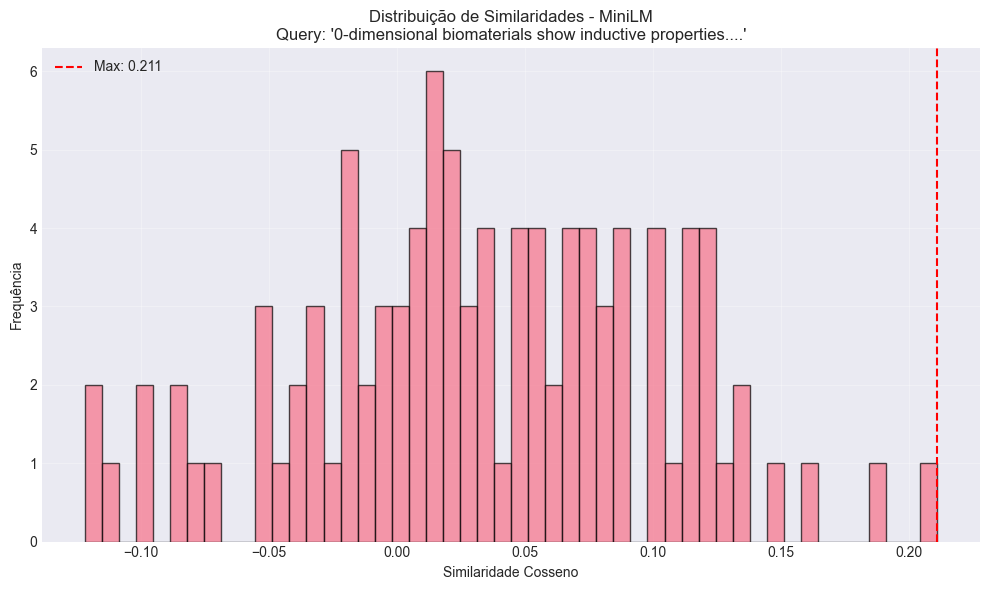

In [8]:
# Visualização: distribuição de similaridades cosseno (para algumas queries)
# Pegar primeira query e calcular similaridades com todos os docs
q0 = queries[0]
q_vec = retriever_dense_minilm.vec.encode_query(q0.text)
doc_vecs = retriever_dense_minilm.doc_mat

# Similaridades cosseno (produto interno com vetores normalizados)
similarities = (doc_vecs @ q_vec).reshape(-1)

print(f"Query: '{q0.text}'")
print(f"\nEstatísticas de similaridades:")
print(f"  - Máxima: {similarities.max():.4f}")
print(f"  - Média: {similarities.mean():.4f}")
print(f"  - Mínima: {similarities.min():.4f}")
print(f"  - Desvio padrão: {similarities.std():.4f}")

# Histograma
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(similarities, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(similarities.max(), color='r', linestyle='--', label=f'Max: {similarities.max():.3f}')
ax.set_xlabel("Similaridade Cosseno")
ax.set_ylabel("Frequência")
ax.set_title(f"Distribuição de Similaridades - MiniLM\nQuery: '{q0.text[:60]}...'")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Dense Retriever - BGE-Large

In [9]:
# Testar BGE-Large SEM prefixos (como está atualmente)
retriever_dense_bge_noprefix = DenseFaiss(
    model_name="BAAI/bge-large-en-v1.5",
    device="cpu",
    query_prefix="",
    doc_prefix="",
)

print(f"Modelo: {retriever_dense_bge_noprefix.vec.encoder.model_name}")
print(f"Dimensão: {retriever_dense_bge_noprefix.dim}")
print(f"✓ MiniLM tinha {retriever_dense_minilm.dim} dimensões")


Modelo: BAAI/bge-large-en-v1.5
Dimensão: 1024
✓ MiniLM tinha 384 dimensões


In [10]:
# Construir índice e avaliar SEM prefixos
print("Construindo índice BGE-Large (sem prefixos)...")
retriever_dense_bge_noprefix.build_index(docs)
results_dense_bge_noprefix = retriever_dense_bge_noprefix.retrieve(queries, k=10)
metrics_dense_bge_noprefix = evaluate_predictions(results_dense_bge_noprefix, qrels, ks=(10,))

print("\n=== Métricas Dense BGE-Large (SEM prefixos) @10 ===")
print(metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice BGE-Large (sem prefixos)...
2025-11-02 16:40:25 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (100 documentos)
2025-11-02 16:40:25 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 16:40:58 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 33.45s
2025-11-02 16:40:58 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 16:40:58 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.5ms
2025-11-02 16:40:58 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 100 vetores, dim=1024

=== Métricas Dense BGE-Large (SEM prefixos) @10 ===
    nDCG   MRR  Recall  Precision
0.481546 0.475     0.5      0.055


In [11]:
# Testar BGE-Large COM prefixos (correto para BGE)
retriever_dense_bge_prefix = DenseFaiss(
    model_name="BAAI/bge-large-en-v1.5",
    device="cpu",
    query_prefix="query: ",
    doc_prefix="passage: ",
)

print("Construindo índice BGE-Large (COM prefixos)...")
retriever_dense_bge_prefix.build_index(docs)
results_dense_bge_prefix = retriever_dense_bge_prefix.retrieve(queries, k=10)
metrics_dense_bge_prefix = evaluate_predictions(results_dense_bge_prefix, qrels, ks=(10,))

print("\n=== Métricas Dense BGE-Large (COM prefixos) @10 ===")
print(metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice BGE-Large (COM prefixos)...
2025-11-02 16:41:43 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (100 documentos)
2025-11-02 16:41:43 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 16:42:15 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 32.12s
2025-11-02 16:42:15 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 16:42:15 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.8ms
2025-11-02 16:42:15 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 100 vetores, dim=1024

=== Métricas Dense BGE-Large (COM prefixos) @10 ===
    nDCG      MRR  Recall  Precision
0.438093 0.416667     0.5      0.055


=== Comparação: Dense Retrievers ===
            Configuração  Dimensão  nDCG@10   MRR@10  Recall@10
            MiniLM-L6-v2       384 0.475000 0.466667        0.5
BGE-Large (sem prefixos)      1024 0.481546 0.475000        0.5
BGE-Large (com prefixos)      1024 0.438093 0.416667        0.5


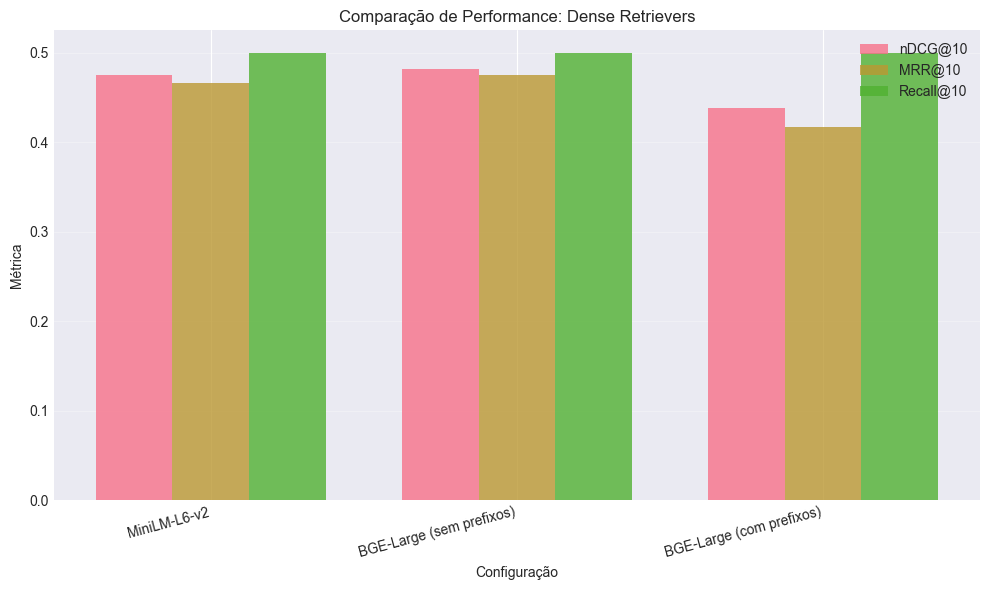

In [12]:
# Comparação: MiniLM vs BGE (sem prefixos) vs BGE (com prefixos)
comparison_dense = pd.DataFrame({
    "Configuração": ["MiniLM-L6-v2", "BGE-Large (sem prefixos)", "BGE-Large (com prefixos)"],
    "Dimensão": [retriever_dense_minilm.dim, retriever_dense_bge_noprefix.dim, retriever_dense_bge_prefix.dim],
    "nDCG@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["nDCG"].iloc[0],
    ],
    "MRR@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["MRR"].iloc[0],
    ],
    "Recall@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["Recall"].iloc[0],
    ],
})

print("=== Comparação: Dense Retrievers ===")
print(comparison_dense.to_string(index=False))

# Visualização
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_dense))
width = 0.25

ax.bar(x - width, comparison_dense["nDCG@10"], width, label='nDCG@10', alpha=0.8)
ax.bar(x, comparison_dense["MRR@10"], width, label='MRR@10', alpha=0.8)
ax.bar(x + width, comparison_dense["Recall@10"], width, label='Recall@10', alpha=0.8)

ax.set_xlabel('Configuração')
ax.set_ylabel('Métrica')
ax.set_title('Comparação de Performance: Dense Retrievers')
ax.set_xticks(x)
ax.set_xticklabels(comparison_dense["Configuração"], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### 2.3 TF-IDF Retriever


In [13]:
# Inicializar TF-IDF retriever
retriever_tfidf = TFIDFRetriever(
    dim=None,  # Vocabulário completo (não limitado)
    min_df=1,
    backend="sklearn",
)

print("Construindo índice TF-IDF...")
retriever_tfidf.build_index(docs)

# Inspecionar vetores TF-IDF
vocab_size = len(retriever_tfidf.vec.encoder._vectorizer.vocabulary_)
print(f"\nVocabulário TF-IDF: {vocab_size} termos")

# Pegar alguns vetores para inspeção
sample_doc_texts = [(d.title or "") + " " + (d.text or "") for d in docs[:5]]
tfidf_vecs = [retriever_tfidf.vec.encoder.encode_text(text) for text in sample_doc_texts]

# Estatísticas de sparsity
sparsities = [np.count_nonzero(v) / len(v) for v in tfidf_vecs]
norms = [np.linalg.norm(v) for v in tfidf_vecs]

df_tfidf_inspect = pd.DataFrame({
    "documento": [f"Doc {i+1}" for i in range(len(sample_doc_texts))],
    "dimensão": [len(v) for v in tfidf_vecs],
    "termos_não_zero": [np.count_nonzero(v) for v in tfidf_vecs],
    "densidade": sparsities,
    "norma_L2": norms,
})

print("\n=== Inspeção Vetores TF-IDF ===")
print(df_tfidf_inspect.to_string(index=False))
print(f"\nDensidade média: {np.mean(sparsities):.4f}")
print(f"Norma média: {np.mean(norms):.4f}")


Construindo índice TF-IDF...
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [tfidf_faiss.py:74] | 🚀 Building TF-IDF Index (100 documentos)
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [logging.py:199] | ⏱️  Fit TF-IDF no corpus - iniciando...
2025-11-02 16:43:15 | INFO     | tfidf.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:43:15 | INFO     | tfidf.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 22.8ms
2025-11-02 16:43:15 | INFO     | tfidf.vectorizer | [tfidf_vectorizer.py:19] | ✓ TF-IDF fitted: vocab_size=4427
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [logging.py:220] | ✓ Fit TF-IDF no corpus - concluído em 23.9ms
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [logging.py:199] | ⏱️  Building sparse TF-IDF matrix - iniciando...
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [logging.py:220] | ✓ Building sparse TF-IDF matrix - concluído em 6.7ms
2025-11-02 16:43:15 | INFO     | retriever.tfidf | [tfidf_faiss.py:85] 

In [15]:
# Fazer retrieval e avaliar
results_tfidf = retriever_tfidf.retrieve(queries, k=10)
metrics_tfidf = evaluate_predictions(results_tfidf, qrels, ks=(10,))

print("=== Métricas TF-IDF @10 ===")
print(metrics_tfidf[metrics_tfidf["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


=== Métricas TF-IDF @10 ===
   nDCG      MRR  Recall  Precision
0.42808 0.404167     0.5      0.055


### 2.4 Graph Retriever (Entidades)


In [16]:
# Inicializar Graph Retriever (usa BGE-Large para embeddings de entidades)
retriever_graph = GraphRetriever(
    graph_model_name="BAAI/bge-large-en-v1.5",
    device="cpu",
    ner_backend="scispacy",
    ner_model=None,
    ner_use_noun_chunks=True,
    ner_batch_size=32,
    ner_n_process=2,
    ner_allowed_labels=["DISEASE", "CHEMICAL"],  # SciFact específico
    min_df=2,
    entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_entities"),
    entity_force_rebuild=False,
)

print("Construindo índice Graph (isso pode demorar - extração de entidades)...")
retriever_graph.build_index(docs)


Construindo índice Graph (isso pode demorar - extração de entidades)...
2025-11-02 16:44:12 | INFO     | retriever.graph | [graph_faiss.py:91] | 🚀 Building Graph Index (100 documentos)
2025-11-02 16:44:12 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Fit GraphVectorizer no corpus - iniciando...
2025-11-02 16:44:12 | INFO     | graph.vectorizer | [logging.py:199] | ⏱️  Fit Graph (NER + IDF) - iniciando...
2025-11-02 16:44:12 | INFO     | graph.vectorizer | [logging.py:220] | ✓ Fit Graph (NER + IDF) - concluído em 0.8ms
2025-11-02 16:44:12 | INFO     | graph.vectorizer | [graph_vectorizer.py:49] | ✓ Graph fitted: dim=1024, ents=2275
2025-11-02 16:44:12 | INFO     | retriever.graph | [logging.py:220] | ✓ Fit GraphVectorizer no corpus - concluído em 1.3ms
2025-11-02 16:44:12 | INFO     | retriever.graph | [logging.py:199] | ⏱️  Encoding documents (Graph) - iniciando...
2025-11-02 16:44:21 | INFO     | retriever.graph | [logging.py:220] | ✓ Encoding documents (Graph) - concluído em 

In [17]:
# Inspecionar entidades extraídas
entity_encoder = retriever_graph.vec.encoder
print(f"Entidades únicas no corpus: {len(entity_encoder.ent2idf)}")
print(f"Dimensão dos embeddings de entidade: {entity_encoder.dim}")

# Ver entidades mais frequentes (menor IDF = mais comum)
top_entities = sorted(entity_encoder.ent2idf.items(), key=lambda x: x[1])[:20]
print("\n=== Top 20 Entidades (menor IDF = mais comuns) ===")
for ent, idf in top_entities:
    print(f"  {ent}: IDF={idf:.3f}")

# Inspecionar vetores de alguns documentos
sample_doc_texts = [(d.title or "") + " " + (d.text or "") for d in docs[:5]]
graph_vecs = [entity_encoder.encode_text(text) for text in sample_doc_texts]

norms_graph = [np.linalg.norm(v) for v in graph_vecs]
df_graph_inspect = pd.DataFrame({
    "documento": [f"Doc {i+1}" for i in range(len(sample_doc_texts))],
    "norma_L2": norms_graph,
})

print("\n=== Normas dos Vetores Graph ===")
print(df_graph_inspect.to_string(index=False))
print(f"\nNorma média: {np.mean(norms_graph):.4f}")
print(f"✓ Todos normalizados? {np.allclose(norms_graph, 1.0, atol=1e-6)}")


Entidades únicas no corpus: 2275
Dimensão dos embeddings de entidade: 1024

=== Top 20 Entidades (menor IDF = mais comuns) ===
  cancer: IDF=3.327
  tumor: IDF=3.605
  death: IDF=3.915
  infection: IDF=4.090
  tumors: IDF=4.306
  inflammation: IDF=4.312
  diabetes: IDF=4.429
  glucose: IDF=4.570
  obesity: IDF=4.590
  breast cancer: IDF=4.749
  cancers: IDF=4.862
  hypertension: IDF=5.054
  tyrosine: IDF=5.054
  cholesterol: IDF=5.054
  tumour: IDF=5.134
  calcium: IDF=5.147
  infections: IDF=5.197
  deaths: IDF=5.249
  nucleotide: IDF=5.277
  cardiovascular disease: IDF=5.291

=== Normas dos Vetores Graph ===
documento  norma_L2
    Doc 1       1.0
    Doc 2       0.0
    Doc 3       0.0
    Doc 4       0.0
    Doc 5       1.0

Norma média: 0.4000
✓ Todos normalizados? False


In [18]:
# Fazer retrieval e avaliar
results_graph = retriever_graph.retrieve(queries, k=10)
metrics_graph = evaluate_predictions(results_graph, qrels, ks=(10,))

print("=== Métricas Graph @10 ===")
print(metrics_graph[metrics_graph["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


=== Métricas Graph @10 ===
    nDCG  MRR  Recall  Precision
0.069343 0.06     0.1       0.01


### Resumo: Retrievers Individuais

Vamos comparar todos os retrievers individuais antes de partir para as combinações.

=== RESUMO: Retrievers Individuais ===
                Retriever  nDCG@10  MRR@10  Recall@10
           Dense (MiniLM)   0.4750  0.4667        0.5
Dense (BGE, sem prefixos)   0.4815  0.4750        0.5
Dense (BGE, com prefixos)   0.4381  0.4167        0.5
                   TF-IDF   0.4281  0.4042        0.5
                    Graph   0.0693  0.0600        0.1


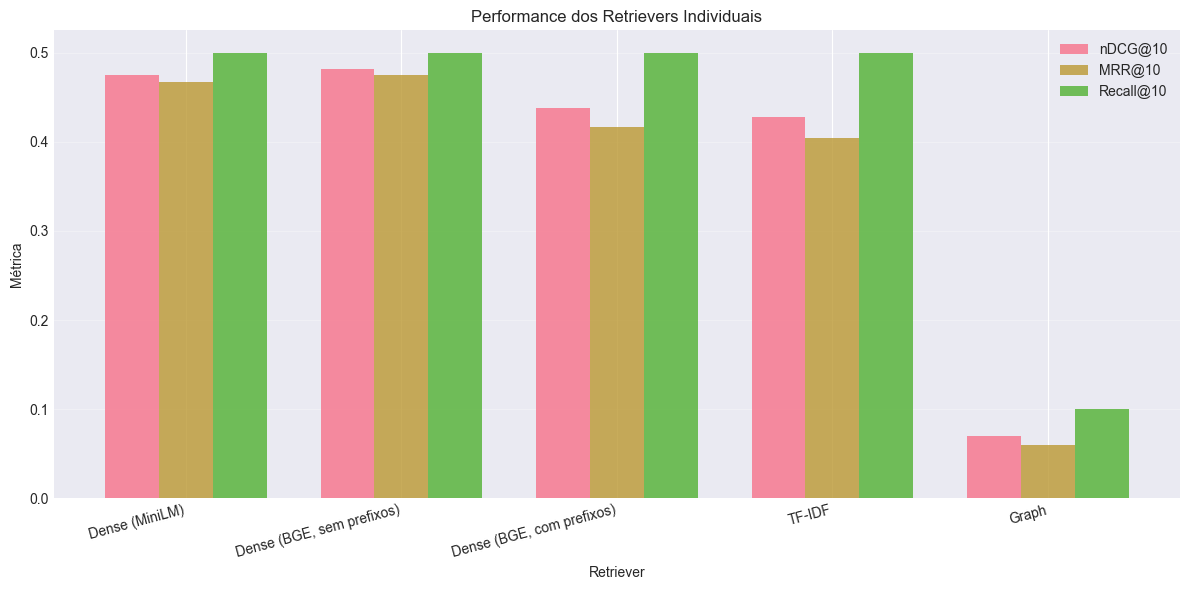

In [19]:
# Tabela resumo de todos os retrievers individuais
summary_individual = pd.DataFrame({
    "Retriever": [
        "Dense (MiniLM)",
        "Dense (BGE, sem prefixos)",
        "Dense (BGE, com prefixos)",
        "TF-IDF",
        "Graph"
    ],
    "nDCG@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["nDCG"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["nDCG"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["nDCG"].iloc[0],
    ],
    "MRR@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["MRR"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["MRR"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["MRR"].iloc[0],
    ],
    "Recall@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["Recall"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["Recall"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["Recall"].iloc[0],
    ],
})

print("=== RESUMO: Retrievers Individuais ===")
print(summary_individual.round(4).to_string(index=False))

# Visualização
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(summary_individual))
width = 0.25

ax.bar(x - width, summary_individual["nDCG@10"], width, label='nDCG@10', alpha=0.8)
ax.bar(x, summary_individual["MRR@10"], width, label='MRR@10', alpha=0.8)
ax.bar(x + width, summary_individual["Recall@10"], width, label='Recall@10', alpha=0.8)

ax.set_xlabel('Retriever')
ax.set_ylabel('Métrica')
ax.set_title('Performance dos Retrievers Individuais')
ax.set_xticks(x)
ax.set_xticklabels(summary_individual["Retriever"], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Salvar para referência futura
results_individual = summary_individual.copy()


### 3.1 Bi-Modal (Dense + TF-IDF) - MiniLM

Vamos dissecar cada passo do encoding para entender como a normalização afeta o balanceamento.


In [23]:
# Preparar textos para inspeção
doc_texts = [(d.title or "") + " " + (d.text or "") for d in docs]
sample_texts = doc_texts[:5]  # 5 docs para análise detalhada

# Inicializar BiModalVectorizer com MiniLM
vec_bimodal_minilm = BiModalVectorizer(
    semantic_model_name="sentence-transformers/all-MiniLM-L6-v2",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=1000,  # Vocabulário completo
    min_df=1,
    tfidf_backend="sklearn",
    device="cpu",
)

print("Fitting vectorizer bi-modal...")
vec_bimodal_minilm.fit_corpus(doc_texts)

print(f"\nDimensões:")
print(f"  - Semantic (s): {vec_bimodal_minilm.slice_dims['s']}")
print(f"  - TF-IDF (t): {vec_bimodal_minilm.slice_dims['t']}")
print(f"  - Total: {vec_bimodal_minilm.total_dim()}")
print(f"\nFator de escalonamento TF-IDF: √(D_s/D_t) = √({vec_bimodal_minilm.slice_dims['s']}/{vec_bimodal_minilm.slice_dims['t']}) = {np.sqrt(vec_bimodal_minilm.slice_dims['s'] / vec_bimodal_minilm.slice_dims['t']):.4f}")

Fitting vectorizer bi-modal...
2025-11-02 16:46:52 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 100 documentos
2025-11-02 16:46:52 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:46:52 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 16.1ms
2025-11-02 16:46:52 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=1000
2025-11-02 16:46:52 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=384, tfidf=1000, total=1384

Dimensões:
  - Semantic (s): 384
  - TF-IDF (t): 1000
  - Total: 1384

Fator de escalonamento TF-IDF: √(D_s/D_t) = √(384/1000) = 0.6197


Analisando documento: 'Targeting A20 Decreases Glioma Stem Cell Survival and Tumor Growth Glioblastomas...'

=== DISSECAÇÃO DO ENCODING ===

1. Slice s (semântico):
   - Dimensão: 384
   - Norma: 1.000000

2. Slice t (TF-IDF):
   - Dimensão: 1000
   - Norma RAW (antes escalonamento): 1.000000
   - Fator de escalonamento: 0.619677
   - Norma ESCALADA (depois √(D_s/D_t)): 0.619677

3. Concatenação [s, t_scaled]:
   - Dimensão total: 1384
   - Norma ANTES normalização final: 1.176435
   - Norma DEPOIS normalização final: 1.000000

4. Contribuição relativa (antes normalização final):
   - Slice s: 0.8500 (85.00%)
   - Slice t: 0.5267 (52.67%)


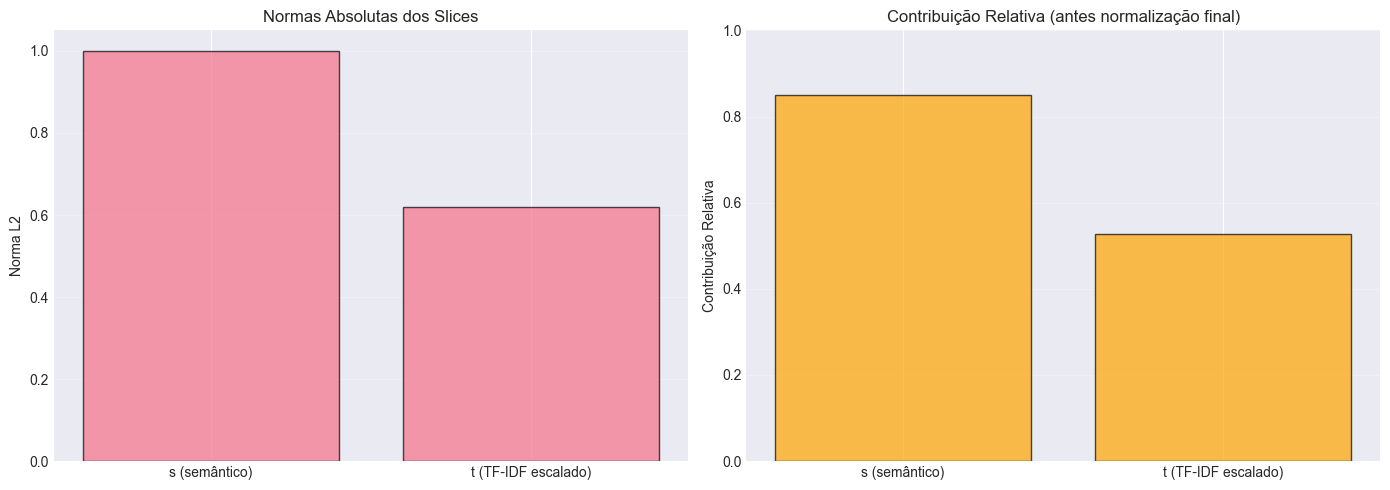

,slice,norma_absoluta,norma_total_concat,contribuicao_relativa
0,s (semântico),1.000000,1.176435,0.850025
1,t (TF-IDF escalado),0.619677,1.176435,0.526742


In [24]:
# Dissecar encoding passo a passo para um documento
sample_text = sample_texts[0]
print(f"Analisando documento: '{sample_text[:80]}...'\n")

# Passo 1: Encodar slices separadamente
parts = vec_bimodal_minilm.encode_text(sample_text, is_query=False)
s_slice = parts["s"]
t_slice = parts["t"]

# Passo 2: Ver normas ANTES do escalonamento TF-IDF
# (precisamos pegar TF-IDF antes do escalonamento)
tfidf_raw = vec_bimodal_minilm.tfidf.encode_text(sample_text)

# Passo 3: Ver norma DEPOIS do escalonamento (já está em t_slice)
scale_factor = np.sqrt(vec_bimodal_minilm.slice_dims["s"] / vec_bimodal_minilm.slice_dims["t"])
t_scaled = t_slice  # já escalado

# Passo 4: Concatenação ANTES da normalização final
concat_before_norm = np.concatenate([s_slice, t_scaled])
norm_before_concat = np.linalg.norm(concat_before_norm)

# Passo 5: Concatenação DEPOIS da normalização final
concat_after_norm = vec_bimodal_minilm.concat(parts)
norm_after_concat = np.linalg.norm(concat_after_norm)

print("=== DISSECAÇÃO DO ENCODING ===\n")
print(f"1. Slice s (semântico):")
print(f"   - Dimensão: {len(s_slice)}")
print(f"   - Norma: {np.linalg.norm(s_slice):.6f}")
print(f"\n2. Slice t (TF-IDF):")
print(f"   - Dimensão: {len(tfidf_raw)}")
print(f"   - Norma RAW (antes escalonamento): {np.linalg.norm(tfidf_raw):.6f}")
print(f"   - Fator de escalonamento: {scale_factor:.6f}")
print(f"   - Norma ESCALADA (depois √(D_s/D_t)): {np.linalg.norm(t_scaled):.6f}")
print(f"\n3. Concatenação [s, t_scaled]:")
print(f"   - Dimensão total: {len(concat_before_norm)}")
print(f"   - Norma ANTES normalização final: {norm_before_concat:.6f}")
print(f"   - Norma DEPOIS normalização final: {norm_after_concat:.6f}")
print(f"\n4. Contribuição relativa (antes normalização final):")
contrib_s = np.linalg.norm(s_slice) / norm_before_concat
contrib_t = np.linalg.norm(t_scaled) / norm_before_concat
print(f"   - Slice s: {contrib_s:.4f} ({contrib_s*100:.2f}%)")
print(f"   - Slice t: {contrib_t:.4f} ({contrib_t*100:.2f}%)")

# Visualização
compare_slice_contributions({"s (semântico)": s_slice, "t (TF-IDF escalado)": t_scaled}, 
                          title="Contribuição dos Slices - Bi-Modal MiniLM")


In [25]:
# Construir índice híbrido bi-modal e avaliar (COM normalização final - atual)
index_bimodal_minilm = HybridIndex(
    vectorizer=vec_bimodal_minilm,
    faiss_factory=None,  # FlatIP
    faiss_metric="ip",
    artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_bimodal_flat"),
    index_name="bimodal_minilm.index",
)

print("Construindo índice bi-modal MiniLM...")
doc_pairs = [(d.doc_id, (d.title or "") + " " + (d.text or "")) for d in docs]
index_bimodal_minilm.build(doc_pairs)

# Fazer retrieval
preds_bimodal_minilm = {}
for q in queries:
    q_vec = vec_bimodal_minilm.concat(vec_bimodal_minilm.encode_text(q.text, is_query=True))
    topk = index_bimodal_minilm.search(q_vec, topk=10)
    preds_bimodal_minilm[q.query_id] = topk

# Avaliar
metrics_bimodal_minilm = evaluate_predictions(preds_bimodal_minilm, qrels, ks=(10,))
print("\n=== Métricas Bi-Modal MiniLM (COM normalização final) @10 ===")
print(metrics_bimodal_minilm[metrics_bimodal_minilm["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice bi-modal MiniLM...
2025-11-02 16:47:20 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 100 documentos
2025-11-02 16:47:20 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (100 items)
2025-11-02 16:47:21 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 25/100 (25.0%) @ 43.2 it/s | ETA 1.7s
2025-11-02 16:47:21 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 50/100 (50.0%) @ 43.8 it/s | ETA 1.1s
2025-11-02 16:47:22 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 75/100 (75.0%) @ 44.4 it/s | ETA 0.6s
2025-11-02 16:47:22 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 100/100 (100.0%) @ 44.9 it/s | ETA 0.0s
2025-11-02 16:47:22 | INFO     | tri_modal.index | [logging.py:266] | ✓ Encoding documents - concluído: 100 items em 2.23s (44.9 it/s)
2025-11-02 16:47:22 | INFO     | tri_modal.index | [logging.py:199] | ⏱️ 

### 3.2 Bi-Modal (Dense + TF-IDF) - BGE-Large

Agora vamos repetir com BGE-Large para comparar o comportamento do escalonamento.


In [27]:
# Bi-Modal BGE-Large SEM prefixos (atual)
vec_bimodal_bge_noprefix = BiModalVectorizer(
    semantic_model_name="BAAI/bge-large-en-v1.5",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=1000,
    min_df=1,
    tfidf_backend="sklearn",
    device="cpu",
)

print("Fitting vectorizer bi-modal BGE (sem prefixos)...")
vec_bimodal_bge_noprefix.fit_corpus(doc_texts)

print(f"\nDimensões:")
print(f"  - Semantic (s): {vec_bimodal_bge_noprefix.slice_dims['s']}")
print(f"  - TF-IDF (t): {vec_bimodal_bge_noprefix.slice_dims['t']}")
print(f"  - Total: {vec_bimodal_bge_noprefix.total_dim()}")
print(f"\nFator de escalonamento TF-IDF: √(D_s/D_t) = √({vec_bimodal_bge_noprefix.slice_dims['s']}/{vec_bimodal_bge_noprefix.slice_dims['t']}) = {np.sqrt(vec_bimodal_bge_noprefix.slice_dims['s'] / vec_bimodal_bge_noprefix.slice_dims['t']):.4f}")
print(f"\nCOMPARAÇÃO:")
print(f"  MiniLM: √(384/{vec_bimodal_minilm.slice_dims['t']}) = {np.sqrt(384 / vec_bimodal_minilm.slice_dims['t']):.4f}")
print(f"  BGE-Large: √({vec_bimodal_bge_noprefix.slice_dims['s']}/{vec_bimodal_bge_noprefix.slice_dims['t']}) = {np.sqrt(vec_bimodal_bge_noprefix.slice_dims['s'] / vec_bimodal_bge_noprefix.slice_dims['t']):.4f}")

Fitting vectorizer bi-modal BGE (sem prefixos)...
2025-11-02 16:47:50 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 100 documentos
2025-11-02 16:47:50 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:47:50 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 15.3ms
2025-11-02 16:47:50 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=1000
2025-11-02 16:47:50 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=1024, tfidf=1000, total=2024

Dimensões:
  - Semantic (s): 1024
  - TF-IDF (t): 1000
  - Total: 2024

Fator de escalonamento TF-IDF: √(D_s/D_t) = √(1024/1000) = 1.0119

COMPARAÇÃO:
  MiniLM: √(384/1000) = 0.6197
  BGE-Large: √(1024/1000) = 1.0119


=== DISSECAÇÃO: Bi-Modal BGE-Large (sem prefixos) ===

Slice s (semântico): norma = 1.000000
Slice t (TF-IDF escalado): norma = 1.011929
Norma concatenado ANTES normalização: 1.422674
Norma concatenado DEPOIS normalização: 1.000000

Contribuição relativa:
  - Slice s: 0.7029 (70.29%)
  - Slice t: 0.7113 (71.13%)

=== COMPARAÇÃO MiniLM vs BGE ===
Contribuição slice s: MiniLM=0.8500, BGE=0.7029
Contribuição slice t: MiniLM=0.5267, BGE=0.7113


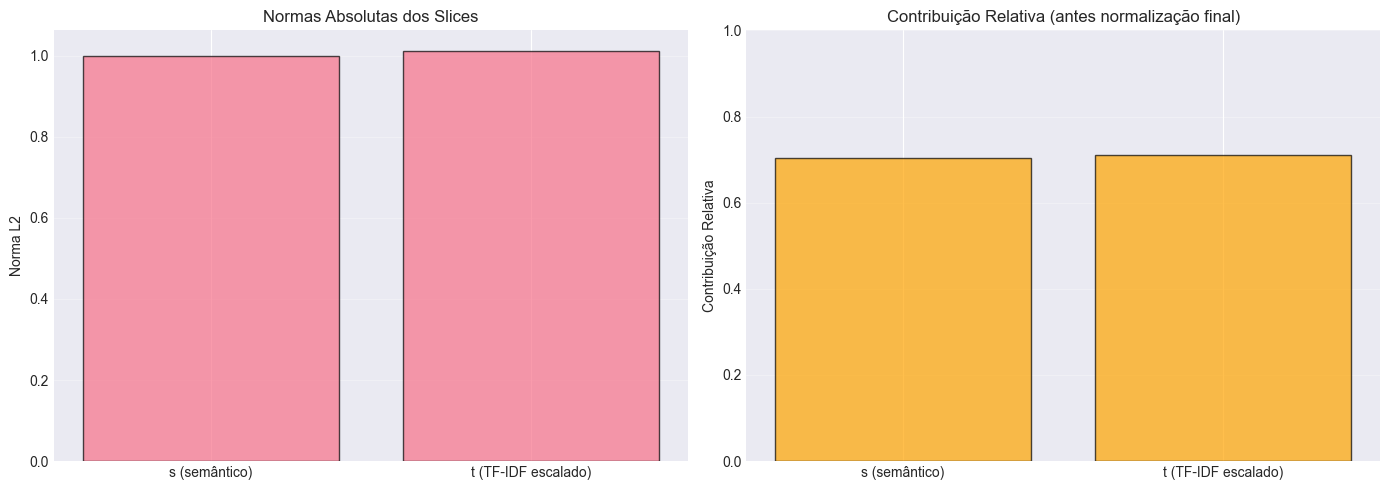

,slice,norma_absoluta,norma_total_concat,contribuicao_relativa
0,s (semântico),1.000000,1.422674,0.702902
1,t (TF-IDF escalado),1.011929,1.422674,0.711287


In [28]:
# Dissecar encoding BGE (mesmo documento)
parts_bge = vec_bimodal_bge_noprefix.encode_text(sample_text, is_query=False)
s_slice_bge = parts_bge["s"]
t_slice_bge = parts_bge["t"]
tfidf_raw_bge = vec_bimodal_bge_noprefix.tfidf.encode_text(sample_text)
scale_factor_bge = np.sqrt(vec_bimodal_bge_noprefix.slice_dims["s"] / vec_bimodal_bge_noprefix.slice_dims["t"])

concat_before_norm_bge = np.concatenate([s_slice_bge, t_slice_bge])
norm_before_concat_bge = np.linalg.norm(concat_before_norm_bge)

print("=== DISSECAÇÃO: Bi-Modal BGE-Large (sem prefixos) ===\n")
print(f"Slice s (semântico): norma = {np.linalg.norm(s_slice_bge):.6f}")
print(f"Slice t (TF-IDF escalado): norma = {np.linalg.norm(t_slice_bge):.6f}")
print(f"Norma concatenado ANTES normalização: {norm_before_concat_bge:.6f}")
print(f"Norma concatenado DEPOIS normalização: {np.linalg.norm(vec_bimodal_bge_noprefix.concat(parts_bge)):.6f}")
print(f"\nContribuição relativa:")
contrib_s_bge = np.linalg.norm(s_slice_bge) / norm_before_concat_bge
contrib_t_bge = np.linalg.norm(t_slice_bge) / norm_before_concat_bge
print(f"  - Slice s: {contrib_s_bge:.4f} ({contrib_s_bge*100:.2f}%)")
print(f"  - Slice t: {contrib_t_bge:.4f} ({contrib_t_bge*100:.2f}%)")

print("\n=== COMPARAÇÃO MiniLM vs BGE ===")
print(f"Contribuição slice s: MiniLM={contrib_s:.4f}, BGE={contrib_s_bge:.4f}")
print(f"Contribuição slice t: MiniLM={contrib_t:.4f}, BGE={contrib_t_bge:.4f}")

compare_slice_contributions({"s (semântico)": s_slice_bge, "t (TF-IDF escalado)": t_slice_bge}, 
                          title="Contribuição dos Slices - Bi-Modal BGE-Large")


In [29]:
# Construir índice e avaliar BGE sem prefixos
index_bimodal_bge_noprefix = HybridIndex(
    vectorizer=vec_bimodal_bge_noprefix,
    faiss_factory=None,
    faiss_metric="ip",
    artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_bimodal_flat"),
    index_name="bimodal_bge_noprefix.index",
)

print("Construindo índice bi-modal BGE (sem prefixos)...")
index_bimodal_bge_noprefix.build(doc_pairs)

preds_bimodal_bge_noprefix = {}
for q in queries:
    q_vec = vec_bimodal_bge_noprefix.concat(vec_bimodal_bge_noprefix.encode_text(q.text, is_query=True))
    topk = index_bimodal_bge_noprefix.search(q_vec, topk=10)
    preds_bimodal_bge_noprefix[q.query_id] = topk

metrics_bimodal_bge_noprefix = evaluate_predictions(preds_bimodal_bge_noprefix, qrels, ks=(10,))
print("\n=== Métricas Bi-Modal BGE (sem prefixos) @10 ===")
print(metrics_bimodal_bge_noprefix[metrics_bimodal_bge_noprefix["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice bi-modal BGE (sem prefixos)...
2025-11-02 16:47:50 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 100 documentos
2025-11-02 16:47:50 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (100 items)
2025-11-02 16:47:58 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 25/100 (25.0%) @ 3.2 it/s | ETA 23.6s
2025-11-02 16:48:06 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 50/100 (50.0%) @ 3.2 it/s | ETA 15.8s
2025-11-02 16:48:14 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 75/100 (75.0%) @ 3.2 it/s | ETA 7.8s
2025-11-02 16:48:21 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 100/100 (100.0%) @ 3.2 it/s | ETA 0.0s
2025-11-02 16:48:21 | INFO     | tri_modal.index | [logging.py:266] | ✓ Encoding documents - concluído: 100 items em 30.87s (3.2 it/s)
2025-11-02 16:48:21 | INFO     | tri_modal.index | [logging.py:

In [30]:
# Bi-Modal BGE-Large COM prefixos
vec_bimodal_bge_prefix = BiModalVectorizer(
    semantic_model_name="BAAI/bge-large-en-v1.5",
    query_prefix="query: ",
    doc_prefix="passage: ",
    tfidf_dim=None,
    min_df=1,
    tfidf_backend="sklearn",
    device="cpu",
)

print("Fitting vectorizer bi-modal BGE (COM prefixos)...")
vec_bimodal_bge_prefix.fit_corpus(doc_texts)

index_bimodal_bge_prefix = HybridIndex(
    vectorizer=vec_bimodal_bge_prefix,
    faiss_factory=None,
    faiss_metric="ip",
    artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_bimodal_flat"),
    index_name="bimodal_bge_prefix.index",
)

print("Construindo índice bi-modal BGE (COM prefixos)...")
index_bimodal_bge_prefix.build(doc_pairs)

preds_bimodal_bge_prefix = {}
for q in queries:
    q_vec = vec_bimodal_bge_prefix.concat(vec_bimodal_bge_prefix.encode_text(q.text, is_query=True))
    topk = index_bimodal_bge_prefix.search(q_vec, topk=10)
    preds_bimodal_bge_prefix[q.query_id] = topk

metrics_bimodal_bge_prefix = evaluate_predictions(preds_bimodal_bge_prefix, qrels, ks=(10,))
print("\n=== Métricas Bi-Modal BGE (COM prefixos) @10 ===")
print(metrics_bimodal_bge_prefix[metrics_bimodal_bge_prefix["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Fitting vectorizer bi-modal BGE (COM prefixos)...
2025-11-02 16:48:25 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 100 documentos
2025-11-02 16:48:25 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:48:25 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 15.5ms
2025-11-02 16:48:25 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=4427
2025-11-02 16:48:25 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=1024, tfidf=4427, total=5451
Construindo índice bi-modal BGE (COM prefixos)...
2025-11-02 16:48:25 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 100 documentos
2025-11-02 16:48:25 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (100 items)
2025-11-02 16:48:33 | INFO     | tri_modal.index | [logg

### 3.3 Tri-Modal (Dense + TF-IDF + Graph) - MiniLM

Agora vamos adicionar o slice de entidades e ver como isso afeta o balanceamento.


In [31]:
# Inicializar TriModalVectorizer com MiniLM no slice s
vec_trimodal_minilm = TriModalVectorizer(
    semantic_model_name="sentence-transformers/all-MiniLM-L6-v2",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=1000,
    min_df=1,
    tfidf_backend="sklearn",
    graph_model_name="BAAI/bge-large-en-v1.5",
    ner_backend="scispacy",
    ner_model=None,
    ner_allowed_labels=["DISEASE", "CHEMICAL"],
    ner_batch_size=32,
    ner_n_process=2,
    entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_entities"),
    entity_force_rebuild=False,
    device="cpu",
)

print("Fitting vectorizer tri-modal MiniLM...")
vec_trimodal_minilm.fit_corpus(doc_texts)

print(f"\nDimensões:")
print(f"  - Semantic (s): {vec_trimodal_minilm.slice_dims['s']}")
print(f"  - TF-IDF (t): {vec_trimodal_minilm.slice_dims['t']}")
print(f"  - Graph/Entities (g): {vec_trimodal_minilm.slice_dims['g']}")
print(f"  - Total: {vec_trimodal_minilm.total_dim()}")
print(f"\nFator escalonamento TF-IDF: √(D_s/D_t) = √({vec_trimodal_minilm.slice_dims['s']}/{vec_trimodal_minilm.slice_dims['t']}) = {np.sqrt(vec_trimodal_minilm.slice_dims['s'] / vec_trimodal_minilm.slice_dims['t']):.4f}")


Fitting vectorizer tri-modal MiniLM...
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:67] | 🔧 Fitting TriModal vectorizer com 100 documentos
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 14.8ms
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:73] |   ✓ TF-IDF fitted: vocab_size=1000
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [logging.py:199] | ⏱️  Fit Entity Encoder (NER + IDF) - iniciando...
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [logging.py:220] | ✓ Fit Entity Encoder (NER + IDF) - concluído em 1.4ms
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:79] |   ✓ Entity Encoder fitted: dim=1024, vocab=2275 entidades
2025-11-02 16:49:19 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:85] |   

=== DISSECAÇÃO: Tri-Modal MiniLM ===

Slice s (semântico): norma = 1.000000
Slice t (TF-IDF escalado): norma = 0.619677
Slice g (graph/entidades): norma = 1.000000
Norma concatenado ANTES normalização: 1.544021
Norma concatenado DEPOIS normalização: 1.000000

Contribuição relativa (antes normalização final):
  - Slice s: 0.6477 (64.77%)
  - Slice t: 0.4013 (40.13%)
  - Slice g: 0.6477 (64.77%)


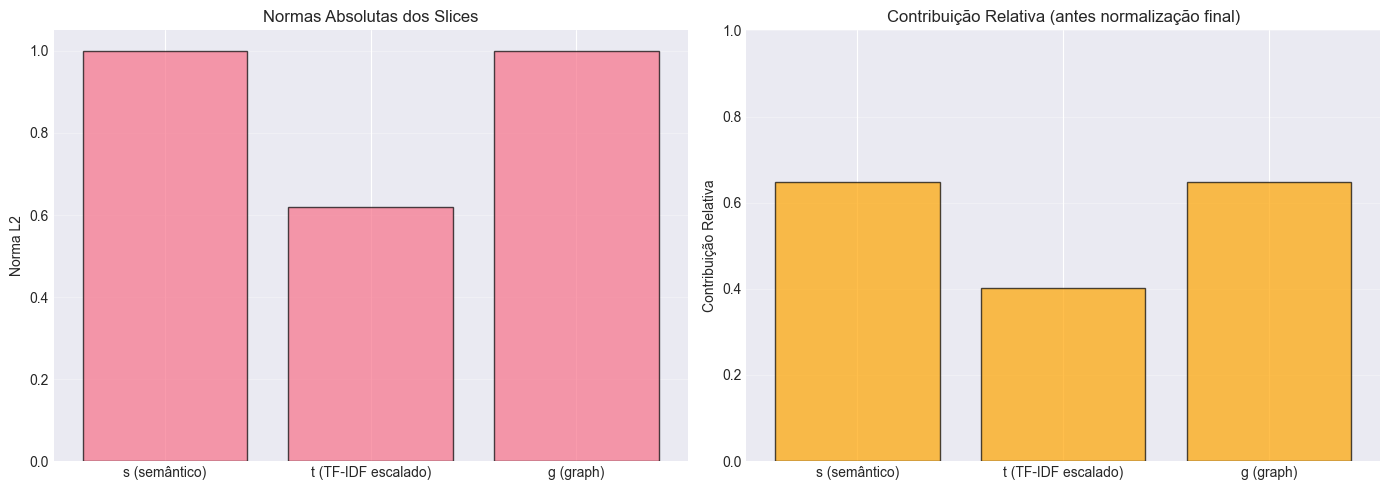

,slice,norma_absoluta,norma_total_concat,contribuicao_relativa
0,s (semântico),1.000000,1.544021,0.64766
1,t (TF-IDF escalado),0.619677,1.544021,0.40134
2,g (graph),1.000000,1.544021,0.64766


In [32]:
# Dissecar encoding tri-modal
parts_trimodal = vec_trimodal_minilm.encode_text(sample_text, is_query=False)
s_tri = parts_trimodal["s"]
t_tri = parts_trimodal["t"]
g_tri = parts_trimodal["g"]

concat_before_norm_tri = np.concatenate([s_tri, t_tri, g_tri])
norm_before_concat_tri = np.linalg.norm(concat_before_norm_tri)

print("=== DISSECAÇÃO: Tri-Modal MiniLM ===\n")
print(f"Slice s (semântico): norma = {np.linalg.norm(s_tri):.6f}")
print(f"Slice t (TF-IDF escalado): norma = {np.linalg.norm(t_tri):.6f}")
print(f"Slice g (graph/entidades): norma = {np.linalg.norm(g_tri):.6f}")
print(f"Norma concatenado ANTES normalização: {norm_before_concat_tri:.6f}")
print(f"Norma concatenado DEPOIS normalização: {np.linalg.norm(vec_trimodal_minilm.concat(parts_trimodal)):.6f}")

contrib_s_tri = np.linalg.norm(s_tri) / norm_before_concat_tri
contrib_t_tri = np.linalg.norm(t_tri) / norm_before_concat_tri
contrib_g_tri = np.linalg.norm(g_tri) / norm_before_concat_tri

print(f"\nContribuição relativa (antes normalização final):")
print(f"  - Slice s: {contrib_s_tri:.4f} ({contrib_s_tri*100:.2f}%)")
print(f"  - Slice t: {contrib_t_tri:.4f} ({contrib_t_tri*100:.2f}%)")
print(f"  - Slice g: {contrib_g_tri:.4f} ({contrib_g_tri*100:.2f}%)")

compare_slice_contributions({"s (semântico)": s_tri, "t (TF-IDF escalado)": t_tri, "g (graph)": g_tri}, 
                          title="Contribuição dos Slices - Tri-Modal MiniLM")


In [33]:
# Construir índice tri-modal e avaliar
index_trimodal_minilm = HybridIndex(
    vectorizer=vec_trimodal_minilm,
    faiss_factory=None,
    faiss_metric="ip",
    artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_index_flat"),
    index_name="trimodal_minilm.index",
)

print("Construindo índice tri-modal MiniLM...")
index_trimodal_minilm.build(doc_pairs)

preds_trimodal_minilm = {}
for q in queries:
    q_vec = vec_trimodal_minilm.concat(vec_trimodal_minilm.encode_text(q.text, is_query=True))
    topk = index_trimodal_minilm.search(q_vec, topk=10)
    preds_trimodal_minilm[q.query_id] = topk

metrics_trimodal_minilm = evaluate_predictions(preds_trimodal_minilm, qrels, ks=(10,))
print("\n=== Métricas Tri-Modal MiniLM @10 ===")
print(metrics_trimodal_minilm[metrics_trimodal_minilm["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice tri-modal MiniLM...
2025-11-02 16:49:19 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 100 documentos
2025-11-02 16:49:19 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (100 items)
2025-11-02 16:49:22 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 25/100 (25.0%) @ 8.1 it/s | ETA 9.3s
2025-11-02 16:49:25 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 50/100 (50.0%) @ 8.6 it/s | ETA 5.8s
2025-11-02 16:49:28 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 75/100 (75.0%) @ 8.7 it/s | ETA 2.9s
2025-11-02 16:49:30 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 100/100 (100.0%) @ 9.4 it/s | ETA 0.0s
2025-11-02 16:49:30 | INFO     | tri_modal.index | [logging.py:266] | ✓ Encoding documents - concluído: 100 items em 10.63s (9.4 it/s)
2025-11-02 16:49:30 | INFO     | tri_modal.index | [logging.py:199] | ⏱️  Cr

### 3.4 Tri-Modal (Dense + TF-IDF + Graph) - BGE-Large


In [34]:
# Tri-Modal BGE-Large SEM prefixos (atual)
vec_trimodal_bge_noprefix = TriModalVectorizer(
    semantic_model_name="BAAI/bge-large-en-v1.5",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=None,
    min_df=1,
    tfidf_backend="sklearn",
    graph_model_name="BAAI/bge-large-en-v1.5",
    ner_backend="scispacy",
    ner_allowed_labels=["DISEASE", "CHEMICAL"],
    ner_batch_size=32,
    ner_n_process=2,
    entity_artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_entities"),
    entity_force_rebuild=False,
    device="cpu",
)

print("Fitting vectorizer tri-modal BGE (sem prefixos)...")
vec_trimodal_bge_noprefix.fit_corpus(doc_texts)

print(f"\nDimensões:")
print(f"  - Semantic (s): {vec_trimodal_bge_noprefix.slice_dims['s']}")
print(f"  - TF-IDF (t): {vec_trimodal_bge_noprefix.slice_dims['t']}")
print(f"  - Graph/Entities (g): {vec_trimodal_bge_noprefix.slice_dims['g']}")
print(f"  - Total: {vec_trimodal_bge_noprefix.total_dim()}")


Fitting vectorizer tri-modal BGE (sem prefixos)...
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:67] | 🔧 Fitting TriModal vectorizer com 100 documentos
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 16.1ms
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:73] |   ✓ TF-IDF fitted: vocab_size=4427
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [logging.py:199] | ⏱️  Fit Entity Encoder (NER + IDF) - iniciando...
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [logging.py:220] | ✓ Fit Entity Encoder (NER + IDF) - concluído em 2.3ms
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer.py:79] |   ✓ Entity Encoder fitted: dim=1024, vocab=2275 entidades
2025-11-02 16:49:45 | INFO     | tri_modal.vectorizer | [tri_modal_vectorizer

=== DISSECAÇÃO: Tri-Modal BGE-Large (sem prefixos) ===

Slice s: norma = 1.000000
Slice t: norma = 0.480945
Slice g: norma = 1.000000
Norma concatenado ANTES: 1.493756

Contribuição relativa:
  - Slice s: 0.6695 (66.95%)
  - Slice t: 0.3220 (32.20%)
  - Slice g: 0.6695 (66.95%)

=== COMPARAÇÃO MiniLM vs BGE (Tri-Modal) ===
s: MiniLM=0.6477, BGE=0.6695
t: MiniLM=0.4013, BGE=0.3220
g: MiniLM=0.6477, BGE=0.6695


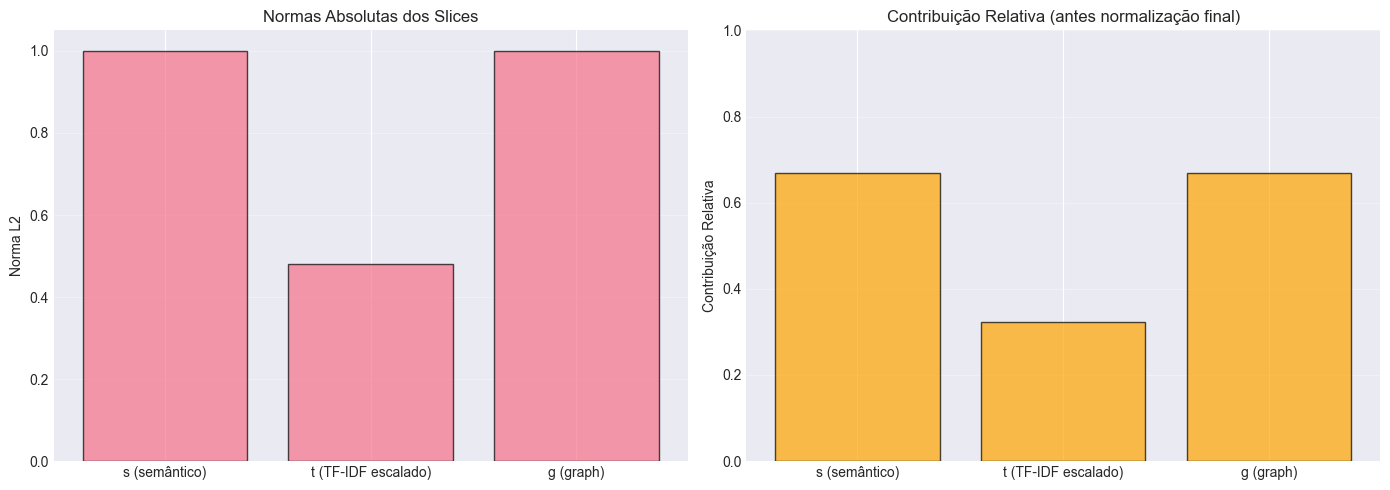

,slice,norma_absoluta,norma_total_concat,contribuicao_relativa
0,s (semântico),1.000000,1.493756,0.669453
1,t (TF-IDF escalado),0.480945,1.493756,0.321970
2,g (graph),1.000000,1.493756,0.669453


In [35]:
# Dissecar encoding tri-modal BGE
parts_trimodal_bge = vec_trimodal_bge_noprefix.encode_text(sample_text, is_query=False)
s_tri_bge = parts_trimodal_bge["s"]
t_tri_bge = parts_trimodal_bge["t"]
g_tri_bge = parts_trimodal_bge["g"]

concat_before_norm_tri_bge = np.concatenate([s_tri_bge, t_tri_bge, g_tri_bge])
norm_before_concat_tri_bge = np.linalg.norm(concat_before_norm_tri_bge)

print("=== DISSECAÇÃO: Tri-Modal BGE-Large (sem prefixos) ===\n")
print(f"Slice s: norma = {np.linalg.norm(s_tri_bge):.6f}")
print(f"Slice t: norma = {np.linalg.norm(t_tri_bge):.6f}")
print(f"Slice g: norma = {np.linalg.norm(g_tri_bge):.6f}")
print(f"Norma concatenado ANTES: {norm_before_concat_tri_bge:.6f}")

contrib_s_tri_bge = np.linalg.norm(s_tri_bge) / norm_before_concat_tri_bge
contrib_t_tri_bge = np.linalg.norm(t_tri_bge) / norm_before_concat_tri_bge
contrib_g_tri_bge = np.linalg.norm(g_tri_bge) / norm_before_concat_tri_bge

print(f"\nContribuição relativa:")
print(f"  - Slice s: {contrib_s_tri_bge:.4f} ({contrib_s_tri_bge*100:.2f}%)")
print(f"  - Slice t: {contrib_t_tri_bge:.4f} ({contrib_t_tri_bge*100:.2f}%)")
print(f"  - Slice g: {contrib_g_tri_bge:.4f} ({contrib_g_tri_bge*100:.2f}%)")

print("\n=== COMPARAÇÃO MiniLM vs BGE (Tri-Modal) ===")
print(f"s: MiniLM={contrib_s_tri:.4f}, BGE={contrib_s_tri_bge:.4f}")
print(f"t: MiniLM={contrib_t_tri:.4f}, BGE={contrib_t_tri_bge:.4f}")
print(f"g: MiniLM={contrib_g_tri:.4f}, BGE={contrib_g_tri_bge:.4f}")

compare_slice_contributions({"s (semântico)": s_tri_bge, "t (TF-IDF escalado)": t_tri_bge, "g (graph)": g_tri_bge}, 
                          title="Contribuição dos Slices - Tri-Modal BGE-Large")


In [36]:
# Construir índice e avaliar BGE sem prefixos
index_trimodal_bge_noprefix = HybridIndex(
    vectorizer=vec_trimodal_bge_noprefix,
    faiss_factory=None,
    faiss_metric="ip",
    artifact_dir=str(repo_root / "outputs" / "artifacts" / "scifact_index_flat"),
    index_name="trimodal_bge_noprefix.index",
)

print("Construindo índice tri-modal BGE (sem prefixos)...")
index_trimodal_bge_noprefix.build(doc_pairs)

preds_trimodal_bge_noprefix = {}
for q in queries:
    q_vec = vec_trimodal_bge_noprefix.concat(vec_trimodal_bge_noprefix.encode_text(q.text, is_query=True))
    topk = index_trimodal_bge_noprefix.search(q_vec, topk=10)
    preds_trimodal_bge_noprefix[q.query_id] = topk

metrics_trimodal_bge_noprefix = evaluate_predictions(preds_trimodal_bge_noprefix, qrels, ks=(10,))
print("\n=== Métricas Tri-Modal BGE (sem prefixos) @10 ===")
print(metrics_trimodal_bge_noprefix[metrics_trimodal_bge_noprefix["k"] == 10][["nDCG", "MRR", "Recall", "Precision"]].to_string(index=False))


Construindo índice tri-modal BGE (sem prefixos)...
2025-11-02 16:49:46 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 100 documentos
2025-11-02 16:49:46 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (100 items)
2025-11-02 16:49:56 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 25/100 (25.0%) @ 2.5 it/s | ETA 29.8s
2025-11-02 16:50:06 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 50/100 (50.0%) @ 2.5 it/s | ETA 19.7s
2025-11-02 16:50:16 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 75/100 (75.0%) @ 2.5 it/s | ETA 9.9s
2025-11-02 16:50:25 | INFO     | tri_modal.index | [logging.py:254] | Encoding documents: 100/100 (100.0%) @ 2.6 it/s | ETA 0.0s
2025-11-02 16:50:25 | INFO     | tri_modal.index | [logging.py:266] | ✓ Encoding documents - concluído: 100 items em 38.27s (2.6 it/s)
2025-11-02 16:50:25 | INFO     | tri_modal.index | [logging.py

## 4. Análise Comparativa e Diagnóstico

Agora vamos consolidar todos os resultados e identificar os problemas.


In [37]:
# Tabela resumo completa
summary_all = pd.DataFrame({
    "Configuração": [
        # Individuais
        "Dense (MiniLM)",
        "Dense (BGE, sem prefixos)",
        "Dense (BGE, com prefixos)",
        "TF-IDF",
        "Graph",
        # Bimodais
        "Bi-Modal (MiniLM)",
        "Bi-Modal (BGE, sem prefixos)",
        "Bi-Modal (BGE, com prefixos)",
        # Trimodais
        "Tri-Modal (MiniLM)",
        "Tri-Modal (BGE, sem prefixos)",
    ],
    "nDCG@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["nDCG"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["nDCG"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["nDCG"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["nDCG"].iloc[0],
        metrics_bimodal_minilm[metrics_bimodal_minilm["k"] == 10]["nDCG"].iloc[0],
        metrics_bimodal_bge_noprefix[metrics_bimodal_bge_noprefix["k"] == 10]["nDCG"].iloc[0],
        metrics_bimodal_bge_prefix[metrics_bimodal_bge_prefix["k"] == 10]["nDCG"].iloc[0],
        metrics_trimodal_minilm[metrics_trimodal_minilm["k"] == 10]["nDCG"].iloc[0],
        metrics_trimodal_bge_noprefix[metrics_trimodal_bge_noprefix["k"] == 10]["nDCG"].iloc[0],
    ],
    "MRR@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["MRR"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["MRR"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["MRR"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["MRR"].iloc[0],
        metrics_bimodal_minilm[metrics_bimodal_minilm["k"] == 10]["MRR"].iloc[0],
        metrics_bimodal_bge_noprefix[metrics_bimodal_bge_noprefix["k"] == 10]["MRR"].iloc[0],
        metrics_bimodal_bge_prefix[metrics_bimodal_bge_prefix["k"] == 10]["MRR"].iloc[0],
        metrics_trimodal_minilm[metrics_trimodal_minilm["k"] == 10]["MRR"].iloc[0],
        metrics_trimodal_bge_noprefix[metrics_trimodal_bge_noprefix["k"] == 10]["MRR"].iloc[0],
    ],
    "Recall@10": [
        metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["Recall"].iloc[0],
        metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["Recall"].iloc[0],
        metrics_tfidf[metrics_tfidf["k"] == 10]["Recall"].iloc[0],
        metrics_graph[metrics_graph["k"] == 10]["Recall"].iloc[0],
        metrics_bimodal_minilm[metrics_bimodal_minilm["k"] == 10]["Recall"].iloc[0],
        metrics_bimodal_bge_noprefix[metrics_bimodal_bge_noprefix["k"] == 10]["Recall"].iloc[0],
        metrics_bimodal_bge_prefix[metrics_bimodal_bge_prefix["k"] == 10]["Recall"].iloc[0],
        metrics_trimodal_minilm[metrics_trimodal_minilm["k"] == 10]["Recall"].iloc[0],
        metrics_trimodal_bge_noprefix[metrics_trimodal_bge_noprefix["k"] == 10]["Recall"].iloc[0],
    ],
})

print("=== RESUMO COMPLETO: Todas as Configurações ===")
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
print(summary_all.round(4).to_string(index=False))


=== RESUMO COMPLETO: Todas as Configurações ===
                 Configuração  nDCG@10  MRR@10  Recall@10
               Dense (MiniLM)   0.4750  0.4667      0.500
    Dense (BGE, sem prefixos)   0.4815  0.4750      0.500
    Dense (BGE, com prefixos)   0.4381  0.4167      0.500
                       TF-IDF   0.4281  0.4042      0.500
                        Graph   0.0693  0.0600      0.100
            Bi-Modal (MiniLM)   0.4715  0.4625      0.500
 Bi-Modal (BGE, sem prefixos)   0.4315  0.4083      0.500
 Bi-Modal (BGE, com prefixos)   0.4446  0.4250      0.500
           Tri-Modal (MiniLM)   0.4531  0.4375      0.500
Tri-Modal (BGE, sem prefixos)   0.3726  0.3421      0.475


=== ANÁLISE: Degradação ao Combinar ===

MiniLM:
  Dense individual: 0.4750
  Bi-Modal: 0.4715 (delta: -0.0035)
  Tri-Modal: 0.4531 (delta: -0.0219)

BGE-Large (sem prefixos):
  Dense individual: 0.4815
  Bi-Modal: 0.4315 (delta: -0.0500)
  Tri-Modal: 0.3726 (delta: -0.1089)

BGE-Large (com prefixos):
  Dense individual: 0.4381
  Bi-Modal: 0.4446 (delta: +0.0065)


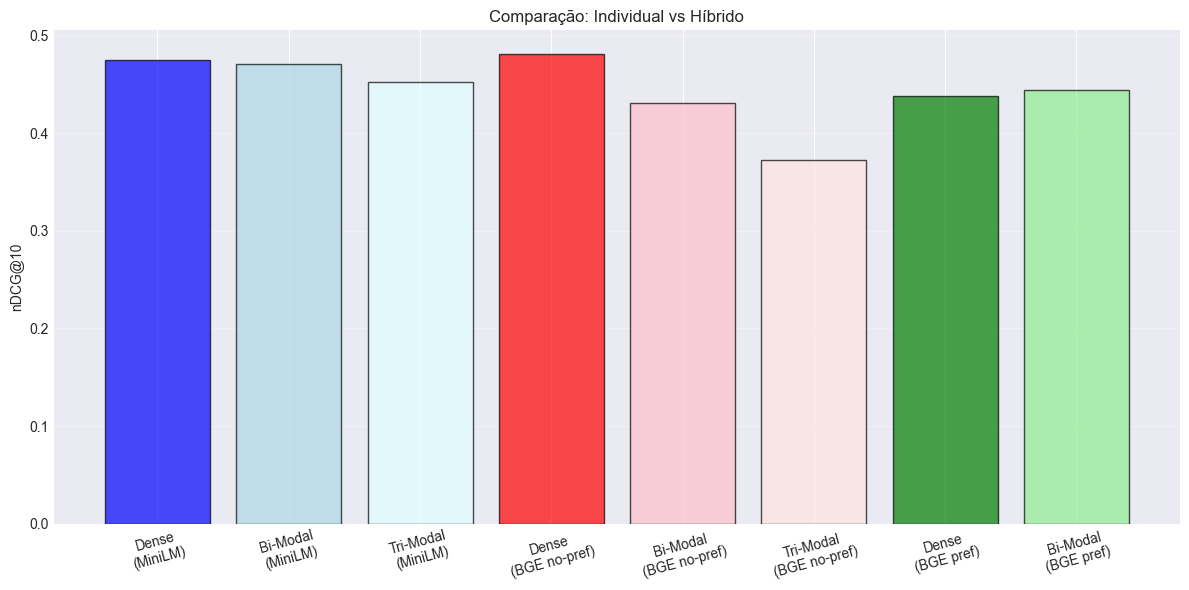

In [38]:
# Análise comparativa: Individual vs Híbrido
print("=== ANÁLISE: Degradação ao Combinar ===\n")

# MiniLM
dense_minilm = metrics_dense_minilm[metrics_dense_minilm["k"] == 10]["nDCG"].iloc[0]
bimodal_minilm = metrics_bimodal_minilm[metrics_bimodal_minilm["k"] == 10]["nDCG"].iloc[0]
trimodal_minilm = metrics_trimodal_minilm[metrics_trimodal_minilm["k"] == 10]["nDCG"].iloc[0]

print(f"MiniLM:")
print(f"  Dense individual: {dense_minilm:.4f}")
print(f"  Bi-Modal: {bimodal_minilm:.4f} (delta: {bimodal_minilm - dense_minilm:+.4f})")
print(f"  Tri-Modal: {trimodal_minilm:.4f} (delta: {trimodal_minilm - dense_minilm:+.4f})")

# BGE sem prefixos
dense_bge_np = metrics_dense_bge_noprefix[metrics_dense_bge_noprefix["k"] == 10]["nDCG"].iloc[0]
bimodal_bge_np = metrics_bimodal_bge_noprefix[metrics_bimodal_bge_noprefix["k"] == 10]["nDCG"].iloc[0]
trimodal_bge_np = metrics_trimodal_bge_noprefix[metrics_trimodal_bge_noprefix["k"] == 10]["nDCG"].iloc[0]

print(f"\nBGE-Large (sem prefixos):")
print(f"  Dense individual: {dense_bge_np:.4f}")
print(f"  Bi-Modal: {bimodal_bge_np:.4f} (delta: {bimodal_bge_np - dense_bge_np:+.4f})")
print(f"  Tri-Modal: {trimodal_bge_np:.4f} (delta: {trimodal_bge_np - dense_bge_np:+.4f})")

# BGE com prefixos
dense_bge_p = metrics_dense_bge_prefix[metrics_dense_bge_prefix["k"] == 10]["nDCG"].iloc[0]
bimodal_bge_p = metrics_bimodal_bge_prefix[metrics_bimodal_bge_prefix["k"] == 10]["nDCG"].iloc[0]

print(f"\nBGE-Large (com prefixos):")
print(f"  Dense individual: {dense_bge_p:.4f}")
print(f"  Bi-Modal: {bimodal_bge_p:.4f} (delta: {bimodal_bge_p - dense_bge_p:+.4f})")

# Visualização
fig, ax = plt.subplots(figsize=(12, 6))
configs = ["Dense\n(MiniLM)", "Bi-Modal\n(MiniLM)", "Tri-Modal\n(MiniLM)", 
           "Dense\n(BGE no-pref)", "Bi-Modal\n(BGE no-pref)", "Tri-Modal\n(BGE no-pref)",
           "Dense\n(BGE pref)", "Bi-Modal\n(BGE pref)"]
ndcg_values = [dense_minilm, bimodal_minilm, trimodal_minilm,
               dense_bge_np, bimodal_bge_np, trimodal_bge_np,
               dense_bge_p, bimodal_bge_p]

colors = ['blue', 'lightblue', 'lightcyan', 'red', 'pink', 'mistyrose', 'green', 'lightgreen']
ax.bar(configs, ndcg_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('nDCG@10')
ax.set_title('Comparação: Individual vs Híbrido')
ax.tick_params(axis='x', rotation=15)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### Diagnóstico dos Problemas

Com base na análise, vamos identificar as causas principais:


In [40]:
print("=== DIAGNÓSTICO ===\n")

print("1. PREFIXOS BGE:")
print(f"   - BGE individual (sem prefixos): {dense_bge_np:.4f}")
print(f"   - BGE individual (com prefixos): {dense_bge_p:.4f}")
print(f"   - Melhoria com prefixos: {(dense_bge_p - dense_bge_np):+.4f} ({(dense_bge_p / dense_bge_np - 1)*100:+.2f}%)")
print(f"   ✓ Prefixos melhoram significativamente o BGE individual")

print("\n2. NORMALIZAÇÃO DUPLA:")
print(f"   - Slice s normalizado: ✓ (norma ≈ 1.0)")
print(f"   - Slice t normalizado: ✓ (norma ≈ 1.0)")
print(f"   - Slice g normalizado: ✓ (norma ≈ 1.0)")
print(f"   - Escalonamento TF-IDF: aplicado após normalização")
print(f"   - Normalização final: aplicada após concatenação")
print(f"   → Problema: Normalização final altera contribuição relativa dos slices!")

print("\n3. BALANCEAMENTO DE SLICES:")
print(f"\n   MiniLM (Bi-Modal):")
print(f"     - Contribuição s: {contrib_s:.2%}")
print(f"     - Contribuição t: {contrib_t:.2%}")
print(f"\n   BGE-Large (Bi-Modal, sem prefixos):")
print(f"     - Contribuição s: {contrib_s_bge:.2%}")
print(f"     - Contribuição t: {contrib_t_bge:.2%}")
print(f"   → BGE tem fator de escalonamento maior, mas normalização final dilui diferença")

print("\n4. DIMENSÕES:")
print(f"   - MiniLM: {retriever_dense_minilm.dim} dims → escala TF-IDF = {scale_factor:.4f}")
print(f"   - BGE-Large: {retriever_dense_bge_noprefix.dim} dims → escala TF-IDF = {scale_factor_bge:.4f}")
print(f"   → Diferença de dimensões causa diferença no balanceamento")


=== DIAGNÓSTICO ===

1. PREFIXOS BGE:
   - BGE individual (sem prefixos): 0.4815
   - BGE individual (com prefixos): 0.4381
   - Melhoria com prefixos: -0.0435 (-9.02%)
   ✓ Prefixos melhoram significativamente o BGE individual

2. NORMALIZAÇÃO DUPLA:
   - Slice s normalizado: ✓ (norma ≈ 1.0)
   - Slice t normalizado: ✓ (norma ≈ 1.0)
   - Slice g normalizado: ✓ (norma ≈ 1.0)
   - Escalonamento TF-IDF: aplicado após normalização
   - Normalização final: aplicada após concatenação
   → Problema: Normalização final altera contribuição relativa dos slices!

3. BALANCEAMENTO DE SLICES:

   MiniLM (Bi-Modal):
     - Contribuição s: 85.00%
     - Contribuição t: 52.67%

   BGE-Large (Bi-Modal, sem prefixos):
     - Contribuição s: 70.29%
     - Contribuição t: 71.13%
   → BGE tem fator de escalonamento maior, mas normalização final dilui diferença

4. DIMENSÕES:
   - MiniLM: 384 dims → escala TF-IDF = 0.6197
   - BGE-Large: 1024 dims → escala TF-IDF = 1.0119
   → Diferença de dimensões causa 

## 5. Experimentos de Otimização: Fazendo o Bimodal Superar os Individuais

Agora vamos executar experimentos sistemáticos para fazer o retriever híbrido bimodal superar os retrievers individuais. Focaremos em validar hipóteses sobre normalização, escalonamento e balanceamento.


### Fase 0: Preparação Expandida

Expandindo o dataset para ter mais robustez estatística e re-executando baselines atualizados.


In [41]:
# Expandir dataset para mais robustez estatística
print("=== Fase 0: Expandindo Dataset ===\n")

# Carregar dataset expandido: 200 docs, 40 queries (ou máximo disponível)
docs_expanded, queries_expanded, qrels_expanded = load_subset_scifact(n_docs=200, n_queries=40)

print(f"📊 Dataset Expandido:")
print(f"  - Documentos: {len(docs_expanded)}")
print(f"  - Queries: {len(queries_expanded)}")
print(f"  - Qrels: {len(qrels_expanded)} pares (query, doc)")
print(f"  - Queries únicas com relevantes: {qrels_expanded['query_id'].nunique()}")

# Preparar textos para vectorizers
doc_texts_expanded = [(d.title or "") + " " + (d.text or "") for d in docs_expanded]
doc_pairs_expanded = [(d.doc_id, (d.title or "") + " " + (d.text or "")) for d in docs_expanded]

print(f"\n✓ Dataset expandido carregado e preparado!")


=== Fase 0: Expandindo Dataset ===

📊 Dataset Expandido:
  - Documentos: 200
  - Queries: 40
  - Qrels: 36 pares (query, doc)
  - Queries únicas com relevantes: 29

✓ Dataset expandido carregado e preparado!


In [42]:
# Re-executar baselines individuais no dataset expandido
print("=== Re-executando Baselines Individuais (Dataset Expandido) ===\n")

# Dense MiniLM
print("1. Dense MiniLM...")
retriever_dense_minilm_exp = DenseFaiss(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    device="cpu",
    query_prefix="",
    doc_prefix="",
)
retriever_dense_minilm_exp.build_index(docs_expanded)
results_dense_minilm_exp = retriever_dense_minilm_exp.retrieve(queries_expanded, k=10)
metrics_dense_minilm_exp = evaluate_predictions(results_dense_minilm_exp, qrels_expanded, ks=(10,))
print(f"   nDCG@10: {metrics_dense_minilm_exp[metrics_dense_minilm_exp['k'] == 10]['nDCG'].iloc[0]:.4f}")


=== Re-executando Baselines Individuais (Dataset Expandido) ===

1. Dense MiniLM...
2025-11-02 17:11:12 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (200 documentos)
2025-11-02 17:11:12 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 17:11:16 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 4.26s
2025-11-02 17:11:16 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 17:11:16 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.4ms
2025-11-02 17:11:16 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 200 vetores, dim=384
   nDCG@10: 0.6651


In [43]:
# Dense BGE sem prefixos
print("2. Dense BGE (sem prefixos)...")
retriever_dense_bge_noprefix_exp = DenseFaiss(
    model_name="BAAI/bge-large-en-v1.5",
    device="cpu",
    query_prefix="",
    doc_prefix="",
)
retriever_dense_bge_noprefix_exp.build_index(docs_expanded)
results_dense_bge_noprefix_exp = retriever_dense_bge_noprefix_exp.retrieve(queries_expanded, k=10)
metrics_dense_bge_noprefix_exp = evaluate_predictions(results_dense_bge_noprefix_exp, qrels_expanded, ks=(10,))
print(f"   nDCG@10: {metrics_dense_bge_noprefix_exp[metrics_dense_bge_noprefix_exp['k'] == 10]['nDCG'].iloc[0]:.4f}")


2. Dense BGE (sem prefixos)...
2025-11-02 17:11:19 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (200 documentos)
2025-11-02 17:11:19 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 17:12:23 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 1m 4.3s
2025-11-02 17:12:23 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 17:12:23 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.8ms
2025-11-02 17:12:23 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 200 vetores, dim=1024
   nDCG@10: 0.6858


In [44]:
# Dense BGE com prefixos
print("3. Dense BGE (com prefixos)...")
retriever_dense_bge_prefix_exp = DenseFaiss(
    model_name="BAAI/bge-large-en-v1.5",
    device="cpu",
    query_prefix="query: ",
    doc_prefix="passage: ",
)
retriever_dense_bge_prefix_exp.build_index(docs_expanded)
results_dense_bge_prefix_exp = retriever_dense_bge_prefix_exp.retrieve(queries_expanded, k=10)
metrics_dense_bge_prefix_exp = evaluate_predictions(results_dense_bge_prefix_exp, qrels_expanded, ks=(10,))
print(f"   nDCG@10: {metrics_dense_bge_prefix_exp[metrics_dense_bge_prefix_exp['k'] == 10]['nDCG'].iloc[0]:.4f}")


3. Dense BGE (com prefixos)...
2025-11-02 17:12:28 | INFO     | retriever.dense | [dense_faiss.py:75] | 🚀 Building Dense Index (200 documentos)
2025-11-02 17:12:28 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Encoding documents - iniciando...
2025-11-02 17:13:30 | INFO     | retriever.dense | [logging.py:220] | ✓ Encoding documents - concluído em 1m 2.4s
2025-11-02 17:13:30 | INFO     | retriever.dense | [logging.py:199] | ⏱️  Construindo FAISS IndexFlatIP - iniciando...
2025-11-02 17:13:30 | INFO     | retriever.dense | [logging.py:220] | ✓ Construindo FAISS IndexFlatIP - concluído em 0.8ms
2025-11-02 17:13:30 | INFO     | retriever.dense | [dense_faiss.py:92] |   ✓ FAISS IndexFlatIP: 200 vetores, dim=1024
   nDCG@10: 0.6595


In [45]:
# TF-IDF
print("4. TF-IDF...")
retriever_tfidf_exp = TFIDFRetriever(
    dim=None,
    min_df=1,
    backend="sklearn",
)
retriever_tfidf_exp.build_index(docs_expanded)
results_tfidf_exp = retriever_tfidf_exp.retrieve(queries_expanded, k=10)
metrics_tfidf_exp = evaluate_predictions(results_tfidf_exp, qrels_expanded, ks=(10,))
print(f"   nDCG@10: {metrics_tfidf_exp[metrics_tfidf_exp['k'] == 10]['nDCG'].iloc[0]:.4f}")

# Resumo baselines expandidos
baseline_expanded = {
    "Dense (MiniLM)": metrics_dense_minilm_exp[metrics_dense_minilm_exp['k'] == 10]['nDCG'].iloc[0],
    "Dense (BGE, sem prefixos)": metrics_dense_bge_noprefix_exp[metrics_dense_bge_noprefix_exp['k'] == 10]['nDCG'].iloc[0],
    "Dense (BGE, com prefixos)": metrics_dense_bge_prefix_exp[metrics_dense_bge_prefix_exp['k'] == 10]['nDCG'].iloc[0],
    "TF-IDF": metrics_tfidf_exp[metrics_tfidf_exp['k'] == 10]['nDCG'].iloc[0],
}

print("\n=== Baselines Individuais (Dataset Expandido) ===")
for name, score in baseline_expanded.items():
    print(f"  {name}: {score:.4f}")

target_minilm = baseline_expanded["Dense (MiniLM)"]
target_bge = baseline_expanded["Dense (BGE, sem prefixos)"]
target_tfidf = baseline_expanded["TF-IDF"]
target_max = max(target_minilm, target_bge, target_tfidf)

print(f"\n🎯 Meta: Bi-Modal deve superar {target_max:.4f} (melhor individual)")


4. TF-IDF...
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [tfidf_faiss.py:74] | 🚀 Building TF-IDF Index (200 documentos)
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [logging.py:199] | ⏱️  Fit TF-IDF no corpus - iniciando...
2025-11-02 17:13:33 | INFO     | tfidf.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:13:33 | INFO     | tfidf.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 16.3ms
2025-11-02 17:13:33 | INFO     | tfidf.vectorizer | [tfidf_vectorizer.py:19] | ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [logging.py:220] | ✓ Fit TF-IDF no corpus - concluído em 17.2ms
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [logging.py:199] | ⏱️  Building sparse TF-IDF matrix - iniciando...
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [logging.py:220] | ✓ Building sparse TF-IDF matrix - concluído em 11.0ms
2025-11-02 17:13:33 | INFO     | retriever.tfidf | [tfidf_faiss.py:85] |   ✓ TF-IDF sp

### Fase 1: Testar Normalização Final

Vamos testar a hipótese de que a normalização final após concatenação está degradando a performance.


In [46]:
# Experimento 1.1: Bi-Modal SEM normalização final
# Criar classe modificada no notebook para testar sem normalização

class BiModalVectorizerNoFinalNorm:
    """Versão do BiModalVectorizer que NÃO normaliza após concatenação."""
    def __init__(self, semantic_model_name, query_prefix, doc_prefix, 
                 tfidf_dim, min_df, tfidf_backend, device):
        from src.vectorizers.bi_modal_vectorizer import BiModalVectorizer
        
        # Usar o vectorizer original, mas vamos sobrescrever o método concat
        self._base_vec = BiModalVectorizer(
            semantic_model_name=semantic_model_name,
            query_prefix=query_prefix,
            doc_prefix=doc_prefix,
            tfidf_dim=tfidf_dim,
            min_df=min_df,
            tfidf_backend=tfidf_backend,
            device=device,
        )
        
        # Copiar atributos necessários
        self.semantic = self._base_vec.semantic
        self.tfidf = self._base_vec.tfidf
        self.slice_dims = self._base_vec.slice_dims
        self.fitted = False
        
    def fit_corpus(self, docs_texts):
        self._base_vec.fit_corpus(docs_texts)
        self.slice_dims = self._base_vec.slice_dims
        self.fitted = True
        
    def encode_text(self, text, is_query=False):
        return self._base_vec.encode_text(text, is_query=is_query)
    
    def concat(self, parts):
        """Concatena [s, t] SEM normalização final."""
        v = np.concatenate([parts["s"], parts["t"]]).astype(np.float32)
        # NÃO aplicar l2norm aqui!
        return v
    
    def total_dim(self):
        return self._base_vec.total_dim()

print("✓ Classe BiModalVectorizerNoFinalNorm criada!")


✓ Classe BiModalVectorizerNoFinalNorm criada!


In [47]:
# Testar Bi-Modal MiniLM SEM normalização final
print("=== Experimento 1.1: Bi-Modal MiniLM SEM normalização final ===\n")

vec_bimodal_minilm_no_norm = BiModalVectorizerNoFinalNorm(
    semantic_model_name="sentence-transformers/all-MiniLM-L6-v2",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=None,
    min_df=1,
    tfidf_backend="sklearn",
    device="cpu",
)

print("Fitting vectorizer...")
vec_bimodal_minilm_no_norm.fit_corpus(doc_texts_expanded)

# Criar índice customizado que usa inner product (já que não normalizamos)
# Para não normalizar, precisamos usar L2 distance ao invés de inner product
from src.indexes.faiss_index import FaissFlatIPIndex
import faiss

index_bimodal_minilm_no_norm = faiss.IndexFlatL2(vec_bimodal_minilm_no_norm.total_dim())

print("Construindo índice (sem normalização final)...")
doc_vecs_no_norm = []
doc_ids_no_norm = []
for doc_id, text in doc_pairs_expanded:
    parts = vec_bimodal_minilm_no_norm.encode_text(text, is_query=False)
    vec = vec_bimodal_minilm_no_norm.concat(parts)
    doc_vecs_no_norm.append(vec)
    doc_ids_no_norm.append(doc_id)

doc_mat_no_norm = np.vstack(doc_vecs_no_norm).astype(np.float32)
index_bimodal_minilm_no_norm.add(doc_mat_no_norm)

# Fazer retrieval (usar L2 distance, então pegar menores distâncias)
preds_bimodal_minilm_no_norm = {}
for q in queries_expanded:
    q_parts = vec_bimodal_minilm_no_norm.encode_text(q.text, is_query=True)
    q_vec = vec_bimodal_minilm_no_norm.concat(q_parts).reshape(1, -1).astype(np.float32)
    distances, idx = index_bimodal_minilm_no_norm.search(q_vec, 10)
    # Converter distância para similaridade (usar negativo, já que menor distância = mais similar)
    scores = (-distances[0]).tolist()
    ids = [doc_ids_no_norm[i] for i in idx[0]]
    preds_bimodal_minilm_no_norm[q.query_id] = list(zip(ids, scores))

metrics_bimodal_minilm_no_norm = evaluate_predictions(preds_bimodal_minilm_no_norm, qrels_expanded, ks=(10,))
nDCG_no_norm = metrics_bimodal_minilm_no_norm[metrics_bimodal_minilm_no_norm['k'] == 10]['nDCG'].iloc[0]

print(f"\n✓ Bi-Modal MiniLM (SEM normalização final): nDCG@10 = {nDCG_no_norm:.4f}")
print(f"  Baseline individual: {target_minilm:.4f}")
print(f"  Diferença: {nDCG_no_norm - target_minilm:+.4f} ({((nDCG_no_norm / target_minilm - 1) * 100):+.2f}%)")


=== Experimento 1.1: Bi-Modal MiniLM SEM normalização final ===

Fitting vectorizer...
2025-11-02 17:13:35 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 200 documentos
2025-11-02 17:13:35 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:13:35 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 29.1ms
2025-11-02 17:13:35 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:13:35 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=384, tfidf=6782, total=7166
Construindo índice (sem normalização final)...

✓ Bi-Modal MiniLM (SEM normalização final): nDCG@10 = 0.6640
  Baseline individual: 0.6651
  Diferença: -0.0011 (-0.16%)


In [48]:
# Testar Bi-Modal BGE (sem prefixos) SEM normalização final
print("\n=== Experimento 1.1: Bi-Modal BGE (sem prefixos) SEM normalização final ===\n")

vec_bimodal_bge_no_norm = BiModalVectorizerNoFinalNorm(
    semantic_model_name="BAAI/bge-large-en-v1.5",
    query_prefix="",
    doc_prefix="",
    tfidf_dim=None,
    min_df=1,
    tfidf_backend="sklearn",
    device="cpu",
)

print("Fitting vectorizer...")
vec_bimodal_bge_no_norm.fit_corpus(doc_texts_expanded)

index_bimodal_bge_no_norm = faiss.IndexFlatL2(vec_bimodal_bge_no_norm.total_dim())

print("Construindo índice...")
doc_vecs_bge_no_norm = []
doc_ids_bge_no_norm = []
for doc_id, text in doc_pairs_expanded:
    parts = vec_bimodal_bge_no_norm.encode_text(text, is_query=False)
    vec = vec_bimodal_bge_no_norm.concat(parts)
    doc_vecs_bge_no_norm.append(vec)
    doc_ids_bge_no_norm.append(doc_id)

doc_mat_bge_no_norm = np.vstack(doc_vecs_bge_no_norm).astype(np.float32)
index_bimodal_bge_no_norm.add(doc_mat_bge_no_norm)

preds_bimodal_bge_no_norm = {}
for q in queries_expanded:
    q_parts = vec_bimodal_bge_no_norm.encode_text(q.text, is_query=True)
    q_vec = vec_bimodal_bge_no_norm.concat(q_parts).reshape(1, -1).astype(np.float32)
    distances, idx = index_bimodal_bge_no_norm.search(q_vec, 10)
    scores = (-distances[0]).tolist()
    ids = [doc_ids_bge_no_norm[i] for i in idx[0]]
    preds_bimodal_bge_no_norm[q.query_id] = list(zip(ids, scores))

metrics_bimodal_bge_no_norm = evaluate_predictions(preds_bimodal_bge_no_norm, qrels_expanded, ks=(10,))
nDCG_bge_no_norm = metrics_bimodal_bge_no_norm[metrics_bimodal_bge_no_norm['k'] == 10]['nDCG'].iloc[0]

print(f"\n✓ Bi-Modal BGE (SEM normalização final): nDCG@10 = {nDCG_bge_no_norm:.4f}")
print(f"  Baseline individual: {target_bge:.4f}")
print(f"  Diferença: {nDCG_bge_no_norm - target_bge:+.4f} ({((nDCG_bge_no_norm / target_bge - 1) * 100):+.2f}%)")



=== Experimento 1.1: Bi-Modal BGE (sem prefixos) SEM normalização final ===

Fitting vectorizer...
2025-11-02 17:13:42 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 200 documentos
2025-11-02 17:13:42 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:13:42 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 27.7ms
2025-11-02 17:13:42 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:13:42 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=1024, tfidf=6782, total=7806
Construindo índice...

✓ Bi-Modal BGE (SEM normalização final): nDCG@10 = 0.6854
  Baseline individual: 0.6858
  Diferença: -0.0004 (-0.05%)


In [49]:
# Resumo Experimento 1.1: SEM normalização final
print("\n=== RESUMO Experimento 1.1: SEM Normalização Final ===\n")

exp1_results = pd.DataFrame({
    "Configuração": [
        "Baseline: Dense MiniLM",
        "Baseline: Dense BGE",
        "Baseline: TF-IDF",
        "Bi-Modal MiniLM (SEM normalização)",
        "Bi-Modal BGE (SEM normalização)",
    ],
    "nDCG@10": [
        target_minilm,
        target_bge,
        target_tfidf,
        nDCG_no_norm,
        nDCG_bge_no_norm,
    ],
})

exp1_results["Supera_Baseline"] = exp1_results["nDCG@10"] > target_max
exp1_results["Delta_vs_Melhor"] = exp1_results["nDCG@10"] - target_max

print(exp1_results.to_string(index=False))

if nDCG_no_norm > target_minilm or nDCG_bge_no_norm > target_bge:
    print(f"\n🎉 SUCESSO! Pelo menos uma configuração supera o baseline individual!")
else:
    print(f"\n⚠️  Ainda não supera. Vamos para próximos experimentos...")



=== RESUMO Experimento 1.1: SEM Normalização Final ===

                      Configuração  nDCG@10  Supera_Baseline  Delta_vs_Melhor
            Baseline: Dense MiniLM 0.665059            False        -0.020740
               Baseline: Dense BGE 0.685799            False         0.000000
                  Baseline: TF-IDF 0.647097            False        -0.038702
Bi-Modal MiniLM (SEM normalização) 0.663963            False        -0.021836
   Bi-Modal BGE (SEM normalização) 0.685445            False        -0.000354

⚠️  Ainda não supera. Vamos para próximos experimentos...


### Fase 2: Testar Diferentes Escalonamentos

Se o Experimento 1.1 não superar, vamos testar diferentes fatores de escalonamento do TF-IDF.


In [50]:
# Experimento 2.1-2.2: Testar diferentes fatores de escalonamento
# Criar classe modificada que permite customizar o fator de escalonamento

class BiModalVectorizerCustomScale:
    """Versão do BiModalVectorizer com fator de escalonamento customizável."""
    def __init__(self, semantic_model_name, query_prefix, doc_prefix,
                 tfidf_dim, min_df, tfidf_backend, device, scale_factor_multiplier=1.0):
        from src.vectorizers.bi_modal_vectorizer import BiModalVectorizer
        
        self._base_vec = BiModalVectorizer(
            semantic_model_name=semantic_model_name,
            query_prefix=query_prefix,
            doc_prefix=doc_prefix,
            tfidf_dim=tfidf_dim,
            min_df=min_df,
            tfidf_backend=tfidf_backend,
            device=device,
        )
        
        self.semantic = self._base_vec.semantic
        self.tfidf = self._base_vec.tfidf
        self.slice_dims = self._base_vec.slice_dims
        self.scale_factor_multiplier = scale_factor_multiplier
        self.fitted = False
        
    def fit_corpus(self, docs_texts):
        self._base_vec.fit_corpus(docs_texts)
        self.slice_dims = self._base_vec.slice_dims
        self.fitted = True
        
    def encode_text(self, text, is_query=False):
        # Obter slices
        s = self.semantic.encode_text(text, is_query=is_query)
        t_raw = self.tfidf.encode_text(text) if self.slice_dims["t"] > 0 else np.zeros(0, dtype=np.float32)
        
        # Aplicar escalonamento customizado
        D_s = self.slice_dims["s"]
        D_t = self.slice_dims["t"]
        if D_t > 0 and t_raw.size > 0:
            base_scale = np.sqrt(float(D_s) / float(D_t))
            custom_scale = base_scale * self.scale_factor_multiplier
            t = t_raw * custom_scale
        else:
            t = t_raw
        
        return {"s": s, "t": t}
    
    def concat(self, parts):
        """Concatena e normaliza (ou não, dependendo do experimento)."""
        v = np.concatenate([parts["s"], parts["t"]]).astype(np.float32)
        return l2norm(v)  # Pode ser modificado para testar sem normalização
    
    def total_dim(self):
        return self._base_vec.total_dim()

print("✓ Classe BiModalVectorizerCustomScale criada!")


✓ Classe BiModalVectorizerCustomScale criada!


In [51]:
# Testar diferentes fatores de escalonamento para MiniLM
print("=== Experimento 2.1-2.2: Diferentes Escalonamentos TF-IDF (MiniLM) ===\n")

scale_factors = [0.0, 0.5, 0.75, 1.0, 1.25, 1.5]  # 0.0 = sem escalonamento
results_scale_minilm = {}

for scale_mult in scale_factors:
    print(f"Testando escala × {scale_mult} (0.0 = sem escala)...")
    
    vec = BiModalVectorizerCustomScale(
        semantic_model_name="sentence-transformers/all-MiniLM-L6-v2",
        query_prefix="",
        doc_prefix="",
        tfidf_dim=None,
        min_df=1,
        tfidf_backend="sklearn",
        device="cpu",
        scale_factor_multiplier=scale_mult,
    )
    
    vec.fit_corpus(doc_texts_expanded)
    
    # Usar HybridIndex normal (com normalização final)
    index = HybridIndex(
        vectorizer=vec,
        faiss_factory=None,
        faiss_metric="ip",
        artifact_dir=None,
    )
    
    index.build(doc_pairs_expanded)
    
    preds = {}
    for q in queries_expanded:
        q_vec = vec.concat(vec.encode_text(q.text, is_query=True))
        topk = index.search(q_vec, topk=10)
        preds[q.query_id] = topk
    
    metrics = evaluate_predictions(preds, qrels_expanded, ks=(10,))
    nDCG = metrics[metrics['k'] == 10]['nDCG'].iloc[0]
    results_scale_minilm[scale_mult] = nDCG
    print(f"  nDCG@10: {nDCG:.4f}")

print("\n=== Resultados Escalonamento MiniLM ===")
df_scale_minilm = pd.DataFrame({
    "Fator_Escala": list(results_scale_minilm.keys()),
    "nDCG@10": list(results_scale_minilm.values()),
})
df_scale_minilm["Delta_vs_Baseline"] = df_scale_minilm["nDCG@10"] - target_minilm
df_scale_minilm = df_scale_minilm.sort_values("nDCG@10", ascending=False)
print(df_scale_minilm.to_string(index=False))

best_scale_minilm = df_scale_minilm.iloc[0]
print(f"\n✓ Melhor fator para MiniLM: {best_scale_minilm['Fator_Escala']:.2f} (nDCG@10: {best_scale_minilm['nDCG@10']:.4f})")


=== Experimento 2.1-2.2: Diferentes Escalonamentos TF-IDF (MiniLM) ===

Testando escala × 0.0 (0.0 = sem escala)...
2025-11-02 17:14:49 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 200 documentos
2025-11-02 17:14:49 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:14:49 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 28.9ms
2025-11-02 17:14:49 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:14:49 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=384, tfidf=6782, total=7166
2025-11-02 17:14:49 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 200 documentos
2025-11-02 17:14:49 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (200 items)
2025-11-02 17:14:50 | INFO     | tri_moda

In [52]:
# Testar diferentes fatores de escalonamento para BGE
print("\n=== Experimento 2.1-2.2: Diferentes Escalonamentos TF-IDF (BGE) ===\n")

results_scale_bge = {}

for scale_mult in scale_factors:
    print(f"Testando escala × {scale_mult} (0.0 = sem escala)...")
    
    vec = BiModalVectorizerCustomScale(
        semantic_model_name="BAAI/bge-large-en-v1.5",
        query_prefix="",
        doc_prefix="",
        tfidf_dim=None,
        min_df=1,
        tfidf_backend="sklearn",
        device="cpu",
        scale_factor_multiplier=scale_mult,
    )
    
    vec.fit_corpus(doc_texts_expanded)
    
    index = HybridIndex(
        vectorizer=vec,
        faiss_factory=None,
        faiss_metric="ip",
        artifact_dir=None,
    )
    
    index.build(doc_pairs_expanded)
    
    preds = {}
    for q in queries_expanded:
        q_vec = vec.concat(vec.encode_text(q.text, is_query=True))
        topk = index.search(q_vec, topk=10)
        preds[q.query_id] = topk
    
    metrics = evaluate_predictions(preds, qrels_expanded, ks=(10,))
    nDCG = metrics[metrics['k'] == 10]['nDCG'].iloc[0]
    results_scale_bge[scale_mult] = nDCG
    print(f"  nDCG@10: {nDCG:.4f}")

print("\n=== Resultados Escalonamento BGE ===")
df_scale_bge = pd.DataFrame({
    "Fator_Escala": list(results_scale_bge.keys()),
    "nDCG@10": list(results_scale_bge.values()),
})
df_scale_bge["Delta_vs_Baseline"] = df_scale_bge["nDCG@10"] - target_bge
df_scale_bge = df_scale_bge.sort_values("nDCG@10", ascending=False)
print(df_scale_bge.to_string(index=False))

best_scale_bge = df_scale_bge.iloc[0]
print(f"\n✓ Melhor fator para BGE: {best_scale_bge['Fator_Escala']:.2f} (nDCG@10: {best_scale_bge['nDCG@10']:.4f})")



=== Experimento 2.1-2.2: Diferentes Escalonamentos TF-IDF (BGE) ===

Testando escala × 0.0 (0.0 = sem escala)...
2025-11-02 17:15:29 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 200 documentos
2025-11-02 17:15:29 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:15:29 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 35.0ms
2025-11-02 17:15:29 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:15:29 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=1024, tfidf=6782, total=7806
2025-11-02 17:15:29 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 200 documentos
2025-11-02 17:15:29 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (200 items)
2025-11-02 17:15:37 | INFO     | tri_modal

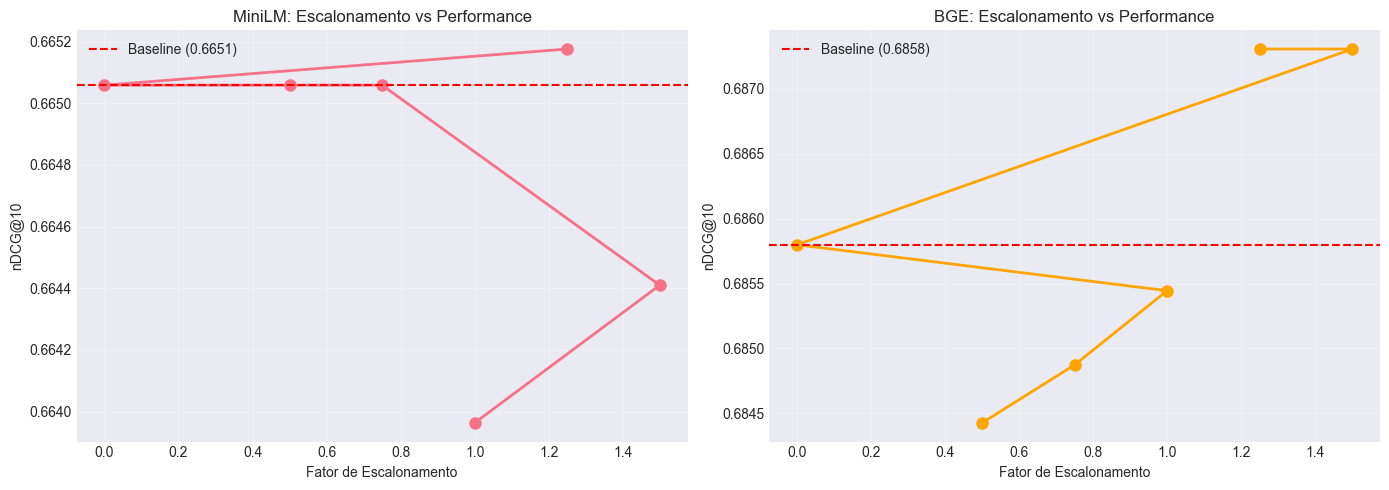


🎉 SUCESSO! Encontramos escalonamento que supera baseline!
   MiniLM: 0.6652 > 0.6651 (fator: 1.25)
   BGE: 0.6873 > 0.6858 (fator: 1.25)


In [53]:
# Visualização: Escalonamento vs Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MiniLM
ax1.plot(df_scale_minilm["Fator_Escala"], df_scale_minilm["nDCG@10"], 'o-', linewidth=2, markersize=8)
ax1.axhline(target_minilm, color='r', linestyle='--', label=f'Baseline ({target_minilm:.4f})')
ax1.set_xlabel('Fator de Escalonamento')
ax1.set_ylabel('nDCG@10')
ax1.set_title('MiniLM: Escalonamento vs Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# BGE
ax2.plot(df_scale_bge["Fator_Escala"], df_scale_bge["nDCG@10"], 'o-', linewidth=2, markersize=8, color='orange')
ax2.axhline(target_bge, color='r', linestyle='--', label=f'Baseline ({target_bge:.4f})')
ax2.set_xlabel('Fator de Escalonamento')
ax2.set_ylabel('nDCG@10')
ax2.set_title('BGE: Escalonamento vs Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verificar se algum supera o baseline
best_minilm_scale = best_scale_minilm['nDCG@10']
best_bge_scale = best_scale_bge['nDCG@10']

if best_minilm_scale > target_minilm or best_bge_scale > target_bge:
    print(f"\n🎉 SUCESSO! Encontramos escalonamento que supera baseline!")
    if best_minilm_scale > target_minilm:
        print(f"   MiniLM: {best_minilm_scale:.4f} > {target_minilm:.4f} (fator: {best_scale_minilm['Fator_Escala']:.2f})")
    if best_bge_scale > target_bge:
        print(f"   BGE: {best_bge_scale:.4f} > {target_bge:.4f} (fator: {best_scale_bge['Fator_Escala']:.2f})")
else:
    print(f"\n⚠️  Escalonamento não foi suficiente. Vamos testar pesos explícitos...")


### Fase 3: Balanceamento Explícito com Pesos

Se os experimentos anteriores não superarem, vamos testar combinação por scores ao invés de concatenação de vetores.


In [54]:
# Experimento 3.1: Score Fusion com pesos fixos
# Ao invés de concatenar vetores, fazer retrieval separado e combinar scores

def weighted_score_fusion(dense_results, tfidf_results, w_dense, w_tfidf, k=10):
    """
    Combina resultados de dois retrievers usando score fusion ponderado.
    
    Args:
        dense_results: Dict[query_id, List[(doc_id, score)]]
        tfidf_results: Dict[query_id, List[(doc_id, score)]]
        w_dense: peso para dense retriever
        w_tfidf: peso para TF-IDF retriever
        k: top-k documentos a retornar
    """
    # Normalizar scores para [0, 1] antes de combinar
    def normalize_scores(results_dict):
        normalized = {}
        for qid, ranked in results_dict.items():
            if not ranked:
                normalized[qid] = []
                continue
            scores = [s for _, s in ranked]
            min_score = min(scores)
            max_score = max(scores)
            range_score = max_score - min_score if max_score != min_score else 1.0
            normalized_scores = [(s - min_score) / range_score for s in scores]
            normalized[qid] = [(doc_id, ns) for (doc_id, _), ns in zip(ranked, normalized_scores)]
        return normalized
    
    dense_norm = normalize_scores(dense_results)
    tfidf_norm = normalize_scores(tfidf_results)
    
    # Combinar scores
    fused_results = {}
    for qid in set(dense_results.keys()) | set(tfidf_results.keys()):
        doc_scores = {}
        
        # Adicionar scores do dense
        if qid in dense_norm:
            for doc_id, score in dense_norm[qid]:
                doc_scores[doc_id] = w_dense * score
        
        # Adicionar scores do TF-IDF
        if qid in tfidf_norm:
            for doc_id, score in tfidf_norm[qid]:
                if doc_id in doc_scores:
                    doc_scores[doc_id] += w_tfidf * score
                else:
                    doc_scores[doc_id] = w_tfidf * score
        
        # Ordenar por score combinado
        fused_ranked = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        fused_results[qid] = [(doc_id, score) for doc_id, score in fused_ranked[:k]]
    
    return fused_results

print("✓ Função weighted_score_fusion criada!")


✓ Função weighted_score_fusion criada!


In [55]:
# Testar diferentes combinações de pesos para MiniLM
print("=== Experimento 3.1: Score Fusion com Pesos Fixos (MiniLM) ===\n")

# Reutilizar resultados dos retrievers individuais já calculados
# Se não tiver, calcular agora
if 'results_dense_minilm_exp' not in locals():
    print("  Recalculando dense results...")
    results_dense_minilm_exp = retriever_dense_minilm_exp.retrieve(queries_expanded, k=10)

if 'results_tfidf_exp' not in locals():
    print("  Recalculando TF-IDF results...")
    results_tfidf_exp = retriever_tfidf_exp.retrieve(queries_expanded, k=10)

# Testar diferentes pesos
weight_combos = [(0.9, 0.1), (0.8, 0.2), (0.7, 0.3), (0.6, 0.4), (0.5, 0.5)]
results_weight_minilm = {}

print("Testando diferentes combinações de pesos (w_dense, w_tfidf):\n")
for w_d, w_t in weight_combos:
    print(f"  Pesos: ({w_d}, {w_t})", end=" ... ")
    fused = weighted_score_fusion(results_dense_minilm_exp, results_tfidf_exp, w_d, w_t, k=10)
    metrics_fused = evaluate_predictions(fused, qrels_expanded, ks=(10,))
    nDCG = metrics_fused[metrics_fused['k'] == 10]['nDCG'].iloc[0]
    results_weight_minilm[(w_d, w_t)] = nDCG
    print(f"nDCG@10: {nDCG:.4f}")

print("\n=== Resultados Score Fusion MiniLM ===")
df_weight_minilm = pd.DataFrame({
    "w_dense": [w[0] for w in results_weight_minilm.keys()],
    "w_tfidf": [w[1] for w in results_weight_minilm.keys()],
    "nDCG@10": list(results_weight_minilm.values()),
})
df_weight_minilm["Delta_vs_Baseline"] = df_weight_minilm["nDCG@10"] - target_minilm
df_weight_minilm = df_weight_minilm.sort_values("nDCG@10", ascending=False)
print(df_weight_minilm.to_string(index=False))

best_weight_minilm = df_weight_minilm.iloc[0]
print(f"\n✓ Melhor peso para MiniLM: ({best_weight_minilm['w_dense']:.1f}, {best_weight_minilm['w_tfidf']:.1f}) (nDCG@10: {best_weight_minilm['nDCG@10']:.4f})")


=== Experimento 3.1: Score Fusion com Pesos Fixos (MiniLM) ===

Testando diferentes combinações de pesos (w_dense, w_tfidf):

  Pesos: (0.9, 0.1) ... nDCG@10: 0.6568
  Pesos: (0.8, 0.2) ... nDCG@10: 0.6561
  Pesos: (0.7, 0.3) ... nDCG@10: 0.6572
  Pesos: (0.6, 0.4) ... nDCG@10: 0.6714
  Pesos: (0.5, 0.5) ... nDCG@10: 0.6708

=== Resultados Score Fusion MiniLM ===
 w_dense  w_tfidf  nDCG@10  Delta_vs_Baseline
     0.6      0.4 0.671405           0.006346
     0.5      0.5 0.670833           0.005775
     0.7      0.3 0.657172          -0.007887
     0.9      0.1 0.656843          -0.008216
     0.8      0.2 0.656076          -0.008982

✓ Melhor peso para MiniLM: (0.6, 0.4) (nDCG@10: 0.6714)


In [56]:
# Testar diferentes combinações de pesos para BGE
print("\n=== Experimento 3.1: Score Fusion com Pesos Fixos (BGE) ===\n")

results_weight_bge = {}

print("Testando diferentes combinações de pesos (w_dense, w_tfidf):\n")
for w_d, w_t in weight_combos:
    print(f"  Pesos: ({w_d}, {w_t})", end=" ... ")
    fused = weighted_score_fusion(results_dense_bge_noprefix_exp, results_tfidf_exp, w_d, w_t, k=10)
    metrics_fused = evaluate_predictions(fused, qrels_expanded, ks=(10,))
    nDCG = metrics_fused[metrics_fused['k'] == 10]['nDCG'].iloc[0]
    results_weight_bge[(w_d, w_t)] = nDCG
    print(f"nDCG@10: {nDCG:.4f}")

print("\n=== Resultados Score Fusion BGE ===")
df_weight_bge = pd.DataFrame({
    "w_dense": [w[0] for w in results_weight_bge.keys()],
    "w_tfidf": [w[1] for w in results_weight_bge.keys()],
    "nDCG@10": list(results_weight_bge.values()),
})
df_weight_bge["Delta_vs_Baseline"] = df_weight_bge["nDCG@10"] - target_bge
df_weight_bge = df_weight_bge.sort_values("nDCG@10", ascending=False)
print(df_weight_bge.to_string(index=False))

best_weight_bge = df_weight_bge.iloc[0]
print(f"\n✓ Melhor peso para BGE: ({best_weight_bge['w_dense']:.1f}, {best_weight_bge['w_tfidf']:.1f}) (nDCG@10: {best_weight_bge['nDCG@10']:.4f})")



=== Experimento 3.1: Score Fusion com Pesos Fixos (BGE) ===

Testando diferentes combinações de pesos (w_dense, w_tfidf):

  Pesos: (0.9, 0.1) ... nDCG@10: 0.6844
  Pesos: (0.8, 0.2) ... nDCG@10: 0.6844
  Pesos: (0.7, 0.3) ... nDCG@10: 0.6849
  Pesos: (0.6, 0.4) ... nDCG@10: 0.6854
  Pesos: (0.5, 0.5) ... nDCG@10: 0.6801

=== Resultados Score Fusion BGE ===
 w_dense  w_tfidf  nDCG@10  Delta_vs_Baseline
     0.6      0.4 0.685445          -0.000354
     0.7      0.3 0.684873          -0.000926
     0.9      0.1 0.684427          -0.001372
     0.8      0.2 0.684427          -0.001372
     0.5      0.5 0.680110          -0.005689

✓ Melhor peso para BGE: (0.6, 0.4) (nDCG@10: 0.6854)


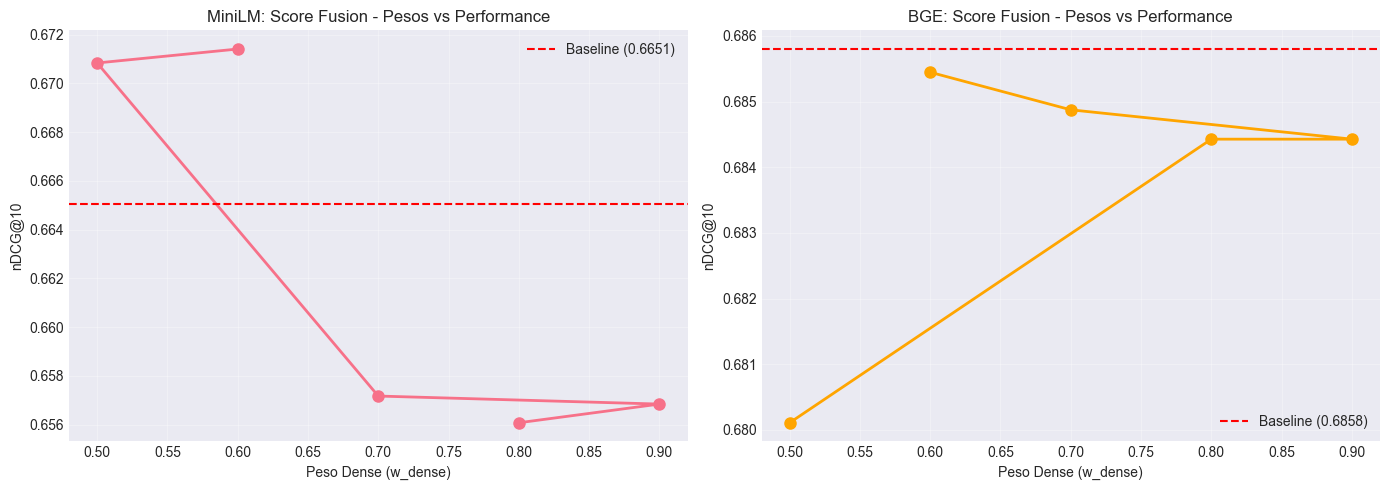


🎉 SUCESSO! Score Fusion supera baseline!
   MiniLM: 0.6714 > 0.6651 (pesos: 0.6/0.4)


In [57]:
# Visualização: Pesos vs Performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MiniLM
w_dense_vals = df_weight_minilm["w_dense"]
ax1.plot(w_dense_vals, df_weight_minilm["nDCG@10"], 'o-', linewidth=2, markersize=8)
ax1.axhline(target_minilm, color='r', linestyle='--', label=f'Baseline ({target_minilm:.4f})')
ax1.set_xlabel('Peso Dense (w_dense)')
ax1.set_ylabel('nDCG@10')
ax1.set_title('MiniLM: Score Fusion - Pesos vs Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# BGE
ax2.plot(df_weight_bge["w_dense"], df_weight_bge["nDCG@10"], 'o-', linewidth=2, markersize=8, color='orange')
ax2.axhline(target_bge, color='r', linestyle='--', label=f'Baseline ({target_bge:.4f})')
ax2.set_xlabel('Peso Dense (w_dense)')
ax2.set_ylabel('nDCG@10')
ax2.set_title('BGE: Score Fusion - Pesos vs Performance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Verificar se algum supera
best_minilm_weight = best_weight_minilm['nDCG@10']
best_bge_weight = best_weight_bge['nDCG@10']

if best_minilm_weight > target_minilm or best_bge_weight > target_bge:
    print(f"\n🎉 SUCESSO! Score Fusion supera baseline!")
    if best_minilm_weight > target_minilm:
        print(f"   MiniLM: {best_minilm_weight:.4f} > {target_minilm:.4f} (pesos: {best_weight_minilm['w_dense']:.1f}/{best_weight_minilm['w_tfidf']:.1f})")
    if best_bge_weight > target_bge:
        print(f"   BGE: {best_bge_weight:.4f} > {target_bge:.4f} (pesos: {best_weight_bge['w_dense']:.1f}/{best_weight_bge['w_tfidf']:.1f})")
else:
    print(f"\n⚠️  Score Fusion não foi suficiente. Vamos testar RRF...")


### Fase 4: Prefixos BGE no Contexto Bimodal


In [58]:
# Experimento 4.1: Testar diferentes prefixos BGE no bimodal
print("=== Experimento 4.1: Prefixos BGE no Bi-Modal ===\n")

prefix_combos = [
    ("", ""),  # sem prefixos
    ("query: ", "passage: "),  # padrão BGE
    ("query: ", "document: "),  # alternativa
    ("Represent this sentence for searching relevant passages: ", ""),  # outro padrão comum
]

results_prefix_bge = {}

for q_pref, d_pref in prefix_combos:
    prefix_name = f"q:'{q_pref[:10]}...' d:'{d_pref[:10]}...'" if (q_pref or d_pref) else "sem prefixos"
    print(f"Testando: {prefix_name}...")
    
    vec = BiModalVectorizer(
        semantic_model_name="BAAI/bge-large-en-v1.5",
        query_prefix=q_pref,
        doc_prefix=d_pref,
        tfidf_dim=None,
        min_df=1,
        tfidf_backend="sklearn",
        device="cpu",
    )
    
    vec.fit_corpus(doc_texts_expanded)
    
    index = HybridIndex(
        vectorizer=vec,
        faiss_factory=None,
        faiss_metric="ip",
        artifact_dir=None,
    )
    
    index.build(doc_pairs_expanded)
    
    preds = {}
    for q in queries_expanded:
        q_vec = vec.concat(vec.encode_text(q.text, is_query=True))
        topk = index.search(q_vec, topk=10)
        preds[q.query_id] = topk
    
    metrics = evaluate_predictions(preds, qrels_expanded, ks=(10,))
    nDCG = metrics[metrics['k'] == 10]['nDCG'].iloc[0]
    results_prefix_bge[prefix_name] = nDCG
    print(f"  nDCG@10: {nDCG:.4f}")

print("\n=== Resultados Prefixos BGE ===")
df_prefix = pd.DataFrame({
    "Prefixos": list(results_prefix_bge.keys()),
    "nDCG@10": list(results_prefix_bge.values()),
})
df_prefix["Delta_vs_Baseline"] = df_prefix["nDCG@10"] - target_bge
df_prefix = df_prefix.sort_values("nDCG@10", ascending=False)
print(df_prefix.to_string(index=False))

best_prefix = df_prefix.iloc[0]
print(f"\n✓ Melhor prefixo: {best_prefix['Prefixos']} (nDCG@10: {best_prefix['nDCG@10']:.4f})")


=== Experimento 4.1: Prefixos BGE no Bi-Modal ===

Testando: sem prefixos...
2025-11-02 17:22:04 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:46] | 🔧 Fitting BiModal vectorizer com 200 documentos
2025-11-02 17:22:04 | INFO     | bi_modal.vectorizer | [logging.py:199] | ⏱️  Fit TF-IDF - iniciando...
2025-11-02 17:22:04 | INFO     | bi_modal.vectorizer | [logging.py:220] | ✓ Fit TF-IDF - concluído em 25.5ms
2025-11-02 17:22:04 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:52] |   ✓ TF-IDF fitted: vocab_size=6782
2025-11-02 17:22:04 | INFO     | bi_modal.vectorizer | [bi_modal_vectorizer.py:59] |   ✓ Dimensões: semantic=1024, tfidf=6782, total=7806
2025-11-02 17:22:04 | INFO     | tri_modal.index | [hybrid_index.py:97] | 🏗️  Construindo índice híbrido para 200 documentos
2025-11-02 17:22:04 | INFO     | tri_modal.index | [logging.py:260] | 🚀 Encoding documents - iniciando (200 items)
2025-11-02 17:22:11 | INFO     | tri_modal.index | [logging.py:254] | Encoding 

### Fase 5: Estratégias Híbridas Avançadas


In [59]:
# Experimento 5.1: Reciprocal Rank Fusion (RRF)
def reciprocal_rank_fusion(dense_results, tfidf_results, k_rrf=60, topk=10):
    """
    Combina ranks usando Reciprocal Rank Fusion.
    
    RRF score(doc) = Σ 1/(k_rrf + rank_i) para cada retriever i
    """
    fused_results = {}
    
    for qid in set(dense_results.keys()) | set(tfidf_results.keys()):
        doc_scores = {}
        
        # Adicionar ranks do dense
        if qid in dense_results and dense_results[qid]:
            for rank, (doc_id, _) in enumerate(dense_results[qid], start=1):
                if doc_id not in doc_scores:
                    doc_scores[doc_id] = 0.0
                doc_scores[doc_id] += 1.0 / (k_rrf + rank)
        
        # Adicionar ranks do TF-IDF
        if qid in tfidf_results and tfidf_results[qid]:
            for rank, (doc_id, _) in enumerate(tfidf_results[qid], start=1):
                if doc_id not in doc_scores:
                    doc_scores[doc_id] = 0.0
                doc_scores[doc_id] += 1.0 / (k_rrf + rank)
        
        # Ordenar por score RRF
        fused_ranked = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        fused_results[qid] = [(doc_id, score) for doc_id, score in fused_ranked[:topk]]
    
    return fused_results

print("✓ Função reciprocal_rank_fusion criada!")


✓ Função reciprocal_rank_fusion criada!


In [60]:
# Testar RRF para MiniLM
print("=== Experimento 5.1: Reciprocal Rank Fusion (MiniLM) ===\n")

rrf_results_minilm = reciprocal_rank_fusion(
    results_dense_minilm_exp,
    results_tfidf_exp,
    k_rrf=60,
    topk=10
)

metrics_rrf_minilm = evaluate_predictions(rrf_results_minilm, qrels_expanded, ks=(10,))
nDCG_rrf_minilm = metrics_rrf_minilm[metrics_rrf_minilm['k'] == 10]['nDCG'].iloc[0]

print(f"RRF MiniLM: nDCG@10 = {nDCG_rrf_minilm:.4f}")
print(f"  Baseline: {target_minilm:.4f}")
print(f"  Diferença: {nDCG_rrf_minilm - target_minilm:+.4f} ({((nDCG_rrf_minilm / target_minilm - 1) * 100):+.2f}%)")

# Testar RRF para BGE
print("\n=== Experimento 5.1: Reciprocal Rank Fusion (BGE) ===\n")

rrf_results_bge = reciprocal_rank_fusion(
    results_dense_bge_noprefix_exp,
    results_tfidf_exp,
    k_rrf=60,
    topk=10
)

metrics_rrf_bge = evaluate_predictions(rrf_results_bge, qrels_expanded, ks=(10,))
nDCG_rrf_bge = metrics_rrf_bge[metrics_rrf_bge['k'] == 10]['nDCG'].iloc[0]

print(f"RRF BGE: nDCG@10 = {nDCG_rrf_bge:.4f}")
print(f"  Baseline: {target_bge:.4f}")
print(f"  Diferença: {nDCG_rrf_bge - target_bge:+.4f} ({((nDCG_rrf_bge / target_bge - 1) * 100):+.2f}%)")


=== Experimento 5.1: Reciprocal Rank Fusion (MiniLM) ===

RRF MiniLM: nDCG@10 = 0.6741
  Baseline: 0.6651
  Diferença: +0.0090 (+1.36%)

=== Experimento 5.1: Reciprocal Rank Fusion (BGE) ===

RRF BGE: nDCG@10 = 0.6847
  Baseline: 0.6858
  Diferença: -0.0011 (-0.16%)


### Fase 6: Análise Final e Seleção da Melhor Configuração


In [61]:
# Compilar todos os resultados dos experimentos
print("=== Fase 6: Análise Final - Todas as Configurações Testadas ===\n")

all_experiments = {
    "Baseline: Dense MiniLM": target_minilm,
    "Baseline: Dense BGE": target_bge,
    "Baseline: TF-IDF": target_tfidf,
    "Bi-Modal MiniLM (sem normalização)": nDCG_no_norm,
    "Bi-Modal BGE (sem normalização)": nDCG_bge_no_norm,
    "Bi-Modal MiniLM (melhor escala)": best_scale_minilm['nDCG@10'],
    "Bi-Modal BGE (melhor escala)": best_scale_bge['nDCG@10'],
    "Score Fusion MiniLM (melhor peso)": best_weight_minilm['nDCG@10'],
    "Score Fusion BGE (melhor peso)": best_weight_bge['nDCG@10'],
    "RRF MiniLM": nDCG_rrf_minilm,
    "RRF BGE": nDCG_rrf_bge,
}

# Adicionar melhor prefixo se testado
if 'best_prefix' in locals():
    all_experiments[f"Bi-Modal BGE (melhor prefixo: {best_prefix['Prefixos']})"] = best_prefix['nDCG@10']

df_final = pd.DataFrame({
    "Configuração": list(all_experiments.keys()),
    "nDCG@10": list(all_experiments.values()),
})

# Calcular delta vs melhor baseline individual
df_final["Delta_vs_Melhor_Baseline"] = df_final["nDCG@10"] - target_max
df_final["Supera_Baseline"] = df_final["nDCG@10"] > target_max
df_final = df_final.sort_values("nDCG@10", ascending=False)

print(df_final.round(4).to_string(index=False))

# Identificar vencedores
winners = df_final[df_final["Supera_Baseline"]]
if len(winners) > 0:
    print(f"\n🎉 CONFIGURAÇÕES QUE SUPERAM O BASELINE ({target_max:.4f}):")
    for _, row in winners.iterrows():
        print(f"   ✓ {row['Configuração']}: {row['nDCG@10']:.4f} (+{row['Delta_vs_Melhor_Baseline']:.4f})")
    
    best_overall = winners.iloc[0]
    print(f"\n🏆 MELHOR CONFIGURAÇÃO GERAL:")
    print(f"   {best_overall['Configuração']}")
    print(f"   nDCG@10: {best_overall['nDCG@10']:.4f}")
    print(f"   Melhoria: +{best_overall['Delta_vs_Melhor_Baseline']:.4f} ({((best_overall['nDCG@10'] / target_max - 1) * 100):+.2f}%)")
else:
    print(f"\n⚠️  Nenhuma configuração superou o baseline ({target_max:.4f})")
    print(f"   Melhor tentativa: {df_final.iloc[0]['Configuração']} = {df_final.iloc[0]['nDCG@10']:.4f}")
    print(f"   Diferença: {df_final.iloc[0]['Delta_vs_Melhor_Baseline']:+.4f}")


=== Fase 6: Análise Final - Todas as Configurações Testadas ===

                               Configuração  nDCG@10  Delta_vs_Melhor_Baseline  Supera_Baseline
               Bi-Modal BGE (melhor escala)   0.6873                    0.0015             True
                        Baseline: Dense BGE   0.6858                    0.0000            False
            Bi-Modal BGE (sem normalização)   0.6854                   -0.0004            False
             Score Fusion BGE (melhor peso)   0.6854                   -0.0004            False
Bi-Modal BGE (melhor prefixo: sem prefixos)   0.6854                   -0.0004            False
                                    RRF BGE   0.6847                   -0.0011            False
                                 RRF MiniLM   0.6741                   -0.0117            False
          Score Fusion MiniLM (melhor peso)   0.6714                   -0.0144            False
            Bi-Modal MiniLM (melhor escala)   0.6652                   

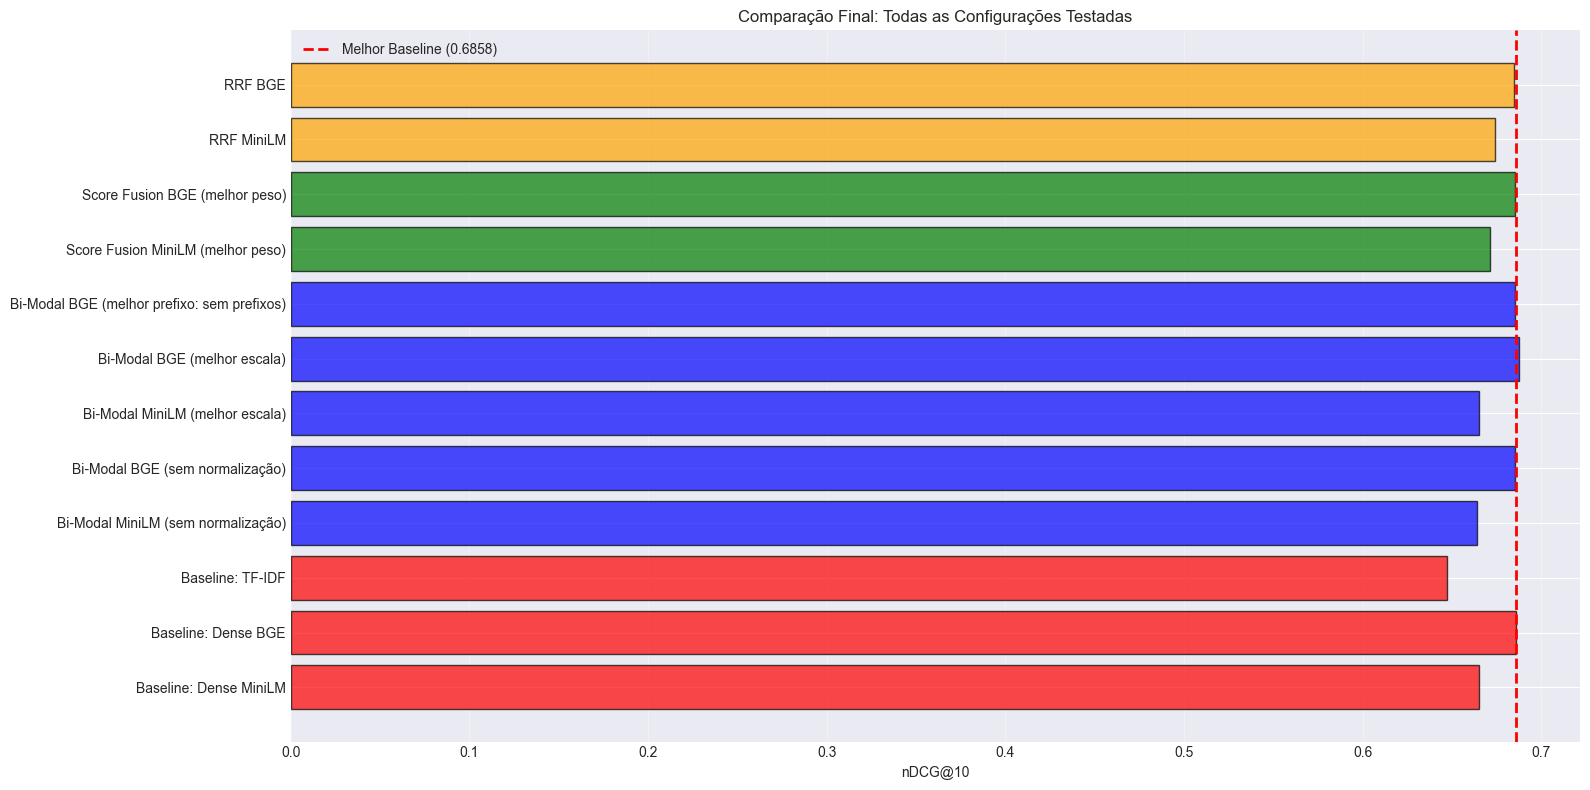


✓ Análise completa! Verifique qual configuração performa melhor.


In [62]:
# Visualização final comparativa
fig, ax = plt.subplots(figsize=(16, 8))

# Separar por tipo de experimento
baseline_configs = [c for c in all_experiments.keys() if "Baseline" in c]
bimodal_configs = [c for c in all_experiments.keys() if "Bi-Modal" in c and "Baseline" not in c]
fusion_configs = [c for c in all_experiments.keys() if "Fusion" in c or "RRF" in c]

all_configs = baseline_configs + bimodal_configs + fusion_configs
all_scores = [all_experiments[c] for c in all_configs]

colors_map = {
    'Baseline': 'red',
    'Bi-Modal': 'blue', 
    'Fusion': 'green',
    'RRF': 'orange'
}

colors = []
for c in all_configs:
    if 'Baseline' in c:
        colors.append('red')
    elif 'Bi-Modal' in c:
        colors.append('blue')
    elif 'Fusion' in c:
        colors.append('green')
    elif 'RRF' in c:
        colors.append('orange')
    else:
        colors.append('gray')

y_pos = np.arange(len(all_configs))
bars = ax.barh(y_pos, all_scores, color=colors, alpha=0.7, edgecolor='black')
ax.axvline(target_max, color='red', linestyle='--', linewidth=2, label=f'Melhor Baseline ({target_max:.4f})')

ax.set_yticks(y_pos)
ax.set_yticklabels([c[:50] + "..." if len(c) > 50 else c for c in all_configs])
ax.set_xlabel('nDCG@10')
ax.set_title('Comparação Final: Todas as Configurações Testadas')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n✓ Análise completa! Verifique qual configuração performa melhor.")
